Paper related to the used dataset: [Semi-supervised machine learning workflow for analysis of nanowire morphologies from transmission electron microscopy images](https://pubs.rsc.org/en/content/articlelanding/2022/dd/d2dd00066k)

Dataset is retrieved from: https://zenodo.org/record/6377141#.ZBzrkuzMIeY

**Note:** The image size in the original dataset is 2048x2048 which is too large to use in Colab. Therefore, the images are downsized to 512x512.

> Protein/peptide nanowires exhibit one of four morphologies
when dispersed in solvent – singular (i.e., isolated nanowire),
dispersed (i.e., isolated collection of multiple nanowires),
network (i.e., percolated nanowires), and bundle morphologies.
Materials with dispersed nanowires are desired for mechanical
reinforcement, while materials with network morphologies are
desired for improving conductivity.



In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import cv2
import os
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import trange
import pandas as pd
from IPython.display import display

# Load dataset

**Common issue:** For macOS user, please check every uploaded folder and remove all the `.DS_Store` files. The `.DS_Store` file is a hidden file that is automatically created by macOS Finder in folders. This file can cause issues when loading a dataset, as it is not an image file and therefore cannot be read by `cv2.imread()` function.

In [66]:
# Load dataset from Google drive
# folder_path needs to be changed
folder_path = '/content/drive/MyDrive/microstructure_dataset'
cla_list = os.listdir(folder_path)
print('The dataset has {} different classes which are: \n{}'.format(len(cla_list), cla_list))

# set the image dimension to 128
dim = 128

# One way of loading images and labels:
# create empty lists to store the loaded images and their corresponding labels
images = []
labels = []

# iterate through the class list
for i in cla_list:
  # print the current class being loaded
  print('Loading class:', i)
  # create the path to the current class folder
  label_path = os.path.join(folder_path, i)
  # get a list of filenames in the current class folder
  filenames = os.listdir(label_path)
  # iterate through each filename in the current class folder
  for j in trange(len(filenames)):
    # create the path to the current image
    single_path = os.path.join(label_path, filenames[j])
    # load the image using OpenCV
    img = cv2.imread(single_path)
    # resize the image to the specified dimension
    img = cv2.resize(img, (dim, dim))
    # append the image to the images list
    images.append(img)
    # get the index of the current class and append it to the labels list
    labels.append(cla_list.index(i))

print('\nIn total, {} images and {} labels are loaded.'.format(len(images), len(labels)))


The dataset has 3 different classes which are: 
['acicular', 'lamellae', 'bi-modal']
Loading class: acicular


100%|██████████| 186/186 [00:02<00:00, 84.97it/s]


Loading class: lamellae


100%|██████████| 688/688 [00:10<00:00, 65.06it/s]


Loading class: bi-modal


100%|██████████| 351/351 [00:06<00:00, 57.62it/s]


In total, 1225 images and 1225 labels are loaded.


In [67]:
images = np.asarray(images)
labels = np.asarray(labels)
print('The shape of images is:', images.shape)
print('The shape of labels is:', labels.shape)

The shape of images is: (1225, 128, 128, 3)
The shape of labels is: (1225,)


# Dataset preprocessing

In [68]:
# Preprocessing
def preprocess_img(img):
  img = np.asarray(img)
  img_mean = img.mean()
  img_std = img.std()
  img = (img - img_mean) / img_std
  img_min = img.min()
  img_minmax = img.max() - img.min()
  img = (img - img_min) / img_minmax
  return img.astype('float32'), img_mean, img_std, img_min, img_minmax
  
def norm_scale_imgs(img, train_mean, train_std, train_min, train_minmax):
  img = np.asarray(img)
  img = (img - train_mean) / train_std
  img = (img - train_min) / train_minmax
  return img.astype('float32')

In [69]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
print('Training set has {} images.'.format(train_imgs.shape[0]))
print('Testing set has {} images.'.format(test_imgs.shape[0]))

Training set has 980 images.
Testing set has 245 images.


In [70]:
# Obtain the index of the first image in the training dataset for each class
train_imgs_to_show = []
for i in range(len(cla_list)):
  idx = np.where(train_labels == i)[0][0]
  train_imgs_to_show.append(idx)

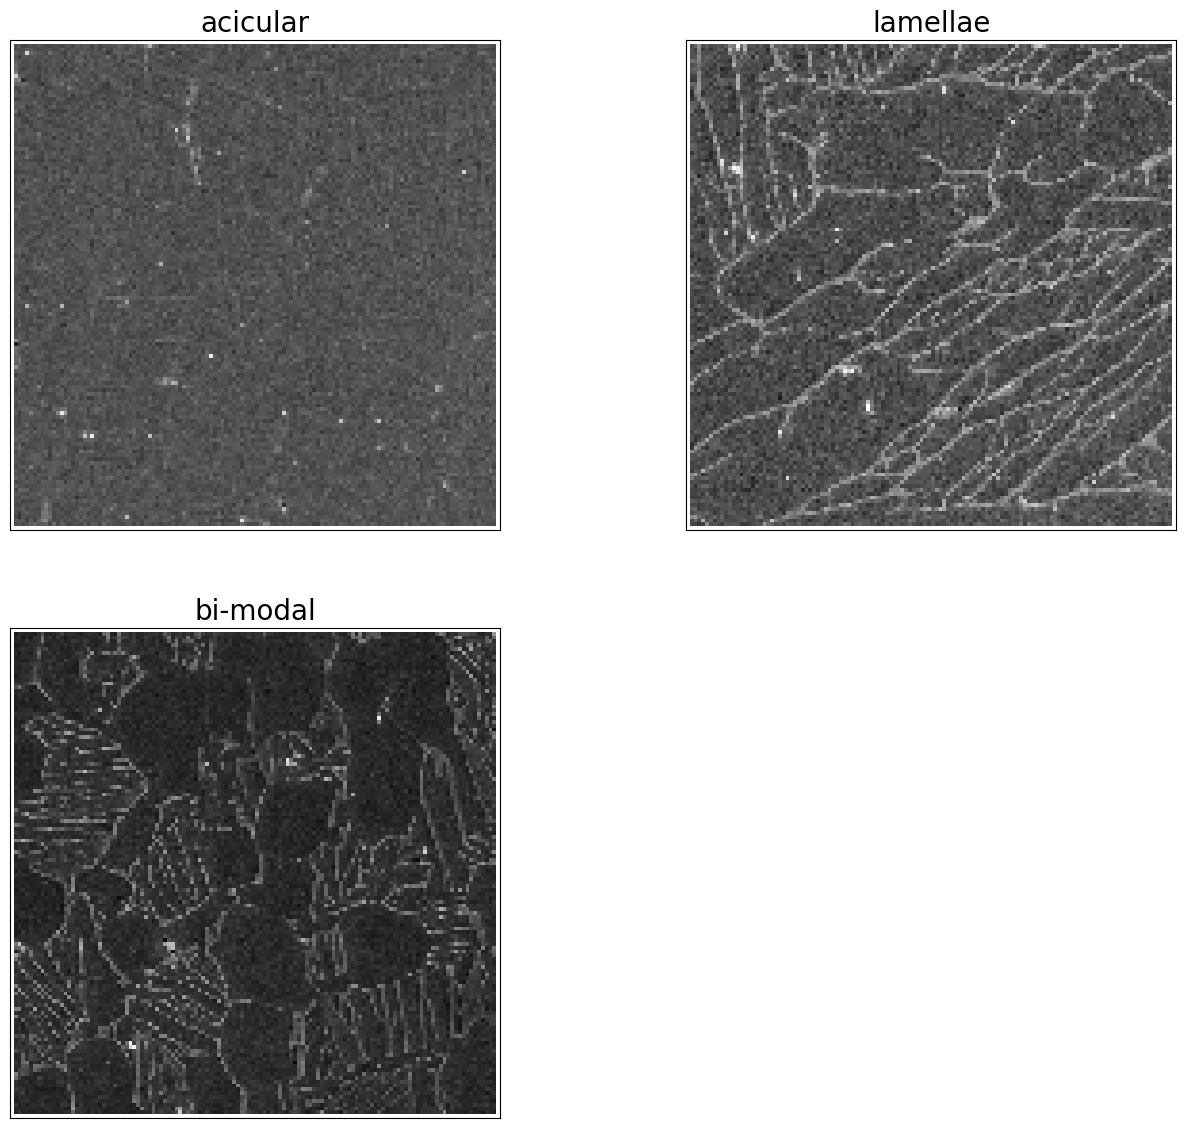

In [71]:
# Show raw data
cont = 0
plt.figure(figsize=(16, 14))
for i in train_imgs_to_show:
  plt.subplot(2, 2,  cont+ 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_imgs[i])
  plt.title('{}'.format(cla_list[train_labels[i]]), fontsize=20)
  cont += 1
plt.show()

Mean: 89.182, Std: 40.090,Min: -2.200, MinMax: 6.336


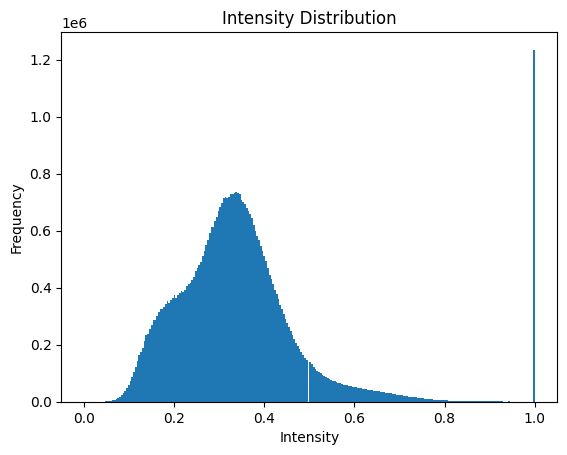

In [72]:
# Normalization
train_imgs_p, train_mean, train_std, train_min, train_minmax = preprocess_img(train_imgs)
test_imgs_p = norm_scale_imgs(test_imgs, train_mean, train_std, train_min, train_minmax)
# Print statistical parameters
print("Mean: {:.3f}, Std: {:.3f},Min: {:.3f}, MinMax: {:.3f}".format(train_mean, train_std, train_min, train_minmax))

# Plot histogram of intensity values
plt.hist(train_imgs_p.flatten(), bins=256, range=(0, 1))
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("Intensity Distribution")
plt.show()


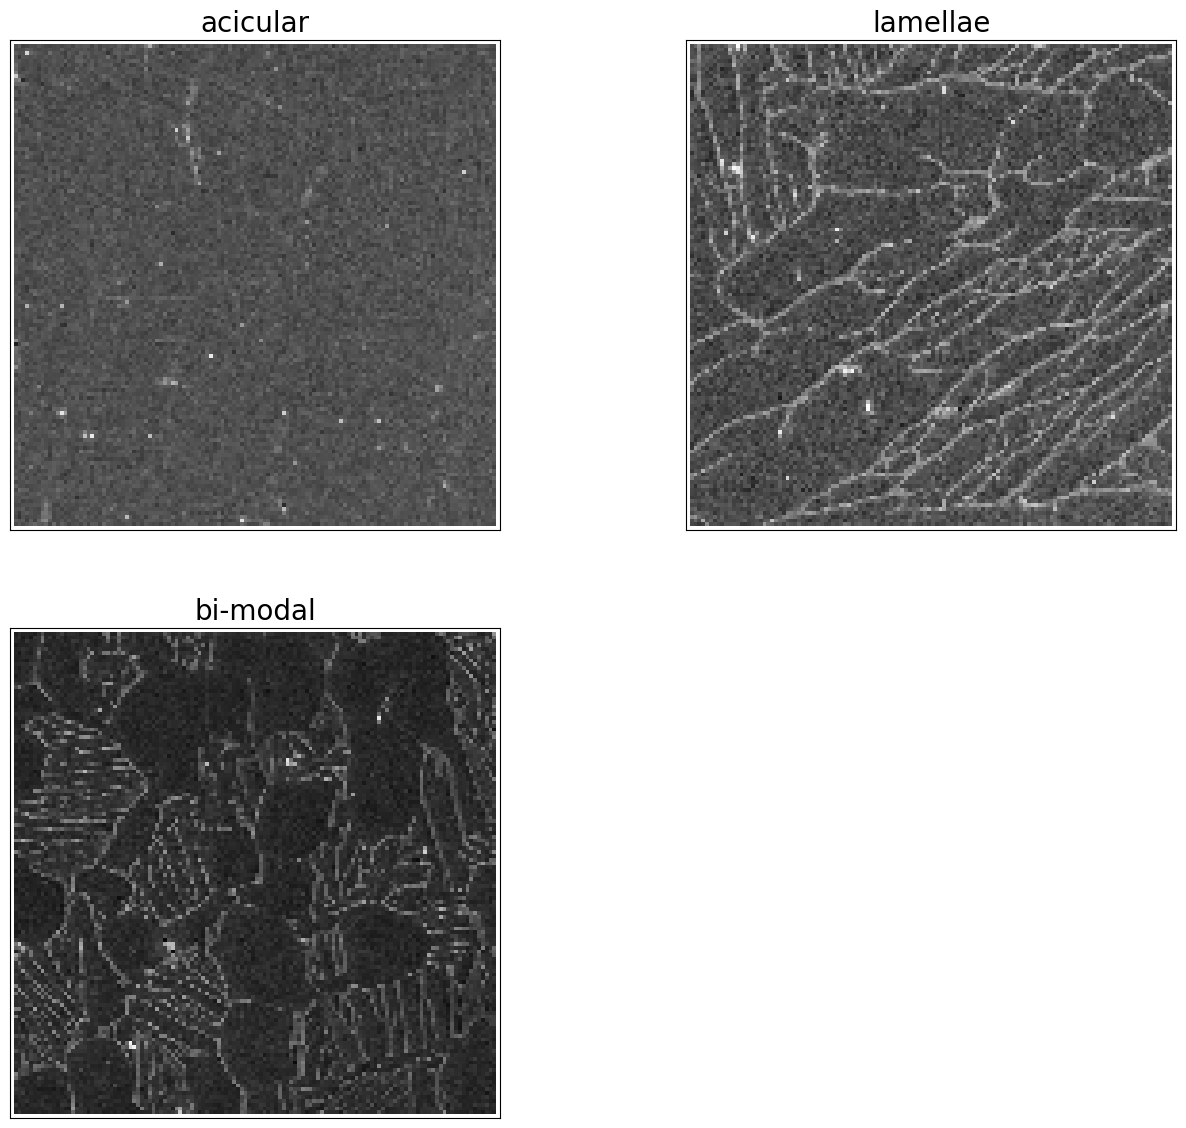

In [73]:
# Show processed data
cont = 0
plt.figure(figsize=(16, 14))
for i in train_imgs_to_show:
  plt.subplot(2, 2,  cont+ 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_imgs_p[i])
  plt.title('{}'.format(cla_list[train_labels[i]]), fontsize=20)
  cont += 1
plt.show()

In [74]:
# Define a custom dataset class called MyDataset which extends the PyTorch's Dataset class.
class MyDataset(Dataset):
  
  # Constructor for the class that initializes the data, targets and optional transformation
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)   # Converting targets to PyTorch's LongTensor data type (to represent integer values)
    self.transform = transform                 # Transform is optional
      
  # Method that returns the item at the given index
  def __getitem__(self, index):
    x = self.data[index]   # Getting data at the given index
    y = self.targets[index] # Getting target for the data at the given index
    
    if self.transform:  # If transformation is provided, apply it on data
        x = self.transform(x)
    
    return x, y
  
  # Method that returns the length of the dataset
  def __len__(self):
    return len(self.data)
  
# Determine whether to use CPU or GPU (if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
# Print which device is being used
print('{} is used.'.format(device))
# Define the transformation to be applied to the data
transform = transforms.Compose([transforms.ToTensor()])
# Create train and test datasets using MyDataset with the given transformations
train_dataset = MyDataset(train_imgs_p, train_labels, transform=transform)
test_dataset = MyDataset(test_imgs_p, test_labels, transform=transform)
# Create DataLoader for train and test datasets with batch size of 200
train_loader = DataLoader(train_dataset, batch_size=200)
test_loader = DataLoader(test_dataset, batch_size=200)


cuda is used.


# CNN model

## Build CNN

In [75]:
# Set the random seed for reproducibility (need to be included to every cell where the random seed is used because each cell in Google Colab runs in a separate session)
seed = 42
torch.manual_seed(seed)

# If GPU is available, set the seed value for it as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Build a CNN class
class CNN(nn.Module):
  # Defining the Constructor
  def __init__(self, num_classes):
    super(CNN, self).__init__()
    
    # In the init function, we define each layer we will use in our model
    
    # Our images are RGB, so we have input channels = 3. 
    # We will apply 16 filters in the first convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  
    # A second convolutional layer takes 16 input channels, and generates 32 outputs
    # We in the end apply max pooling with a kernel size of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # We need to flatten these in order to feed them to a fully-connected layer
    self.fc = nn.Linear(in_features=int(dim/4) * int(dim/4) * 32, out_features=num_classes) # dim/4 due to two maxpool with kernel size =2 

  def forward(self, x, return_feature_maps=False):
    # In the forward function, pass the data through the layers we defined in the init function
    # Note: max-pooling and monotonely increasing non-linearities commute. 
    # This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input. 
    # But Relu(MaxPool(x)) is much faster by doing less amount of operations.
    
    # Save the feature maps after each convolutional blocks
    feature_map1 = F.relu(self.pool1(self.conv1(x)))
    feature_map2 = F.relu(self.pool2(self.conv2(feature_map1)))

    # Flatten
    x = torch.flatten(feature_map2, 1)

    # Feed to fully-connected layer to predict class
    x = self.fc(x)

    # Return class probabilities via a softmax function
    output = torch.softmax(x, dim=1)

    if return_feature_maps:
      return output, [feature_map1, feature_map2]
    else:
      return output

# Helper function for train, test, and evaluation
def train(model, device, train_loader, optimizer, epoch):
  # Set the model to training mode
  model.train()
  train_loss = 0
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
    # Use the CPU or GPU as appropriate
    # Recall that GPU is optimized for the operations we are dealing with
    data, target = data.to(device), target.to(device)
    # Reset the optimizer
    optimizer.zero_grad()
    # Push the data forward through the model layers
    output = model(data)
    # Get the loss
    loss = loss_criteria(output, target)
    # Keep a running total
    train_loss += loss.item()
    # Backpropagate
    loss.backward()
    optimizer.step()
          
  # return average loss for the epoch
  avg_loss = train_loss / (batch_idx+1)
  return avg_loss

def test(model, device, test_loader):
  # Switch the model to evaluation mode (so we don't backpropagate or drop)
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    batch_count = 0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)
      # Get the predicted classes for this batch
      output = model(data)
      # Calculate the loss for this batch
      test_loss += loss_criteria(output, target).item()
      # Calculate the accuracy for this batch
      _, predicted = torch.max(output.data, 1)
      correct += torch.sum(target==predicted).item()

  # Calculate the average loss and total accuracy for this epoch
  avg_loss = test_loss / batch_count
  
  # return average loss for the epoch
  return avg_loss, correct

def eval_test(model, device, test_loader):
  # Switch the model to evaluation mode (so we don't backpropagate or drop)
  model.eval()

  predictions = []
  num_correct = 0
  with torch.no_grad():
    batch_count = 0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)
      
      # Get the predicted classes for this batch
      output = model(data)
      
      # Calculate the accuracy for this batch
      _, predicted = torch.max(output.data, 1)
      num_correct += torch.sum(target==predicted).item()
      predictions.append(predicted.cpu().numpy().flatten())
          
  return predictions, num_correct

# Create an instance of the model class and allocate it to the device
model_cnn = CNN(num_classes=len(cla_list)).to(device)

print(model_cnn)
print('---'*30)
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
testing_loss = []

print('Training on', device)
num_epoch = 100
pbar = trange(num_epoch) # For processing bar
for epoch in pbar:

  train_loss = train(model_cnn, device, train_loader, optimizer, epoch)
  test_loss, correct = test(model_cnn, device, test_loader)
  
  epoch_nums.append(epoch)
  training_loss.append(train_loss)
  testing_loss.append(test_loss)
  accuracy_cnn = correct / len(test_loader.dataset)
  pbar.set_postfix({'Train loss': training_loss[-1], 'Test loss': testing_loss[-1], 'Test accuracy': correct / len(test_loader.dataset)})

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32768, out_features=3, bias=True)
)
------------------------------------------------------------------------------------------
Training on cuda


100%|██████████| 100/100 [00:43<00:00,  2.32it/s, Train loss=0.569, Test loss=0.573, Test accuracy=0.976]


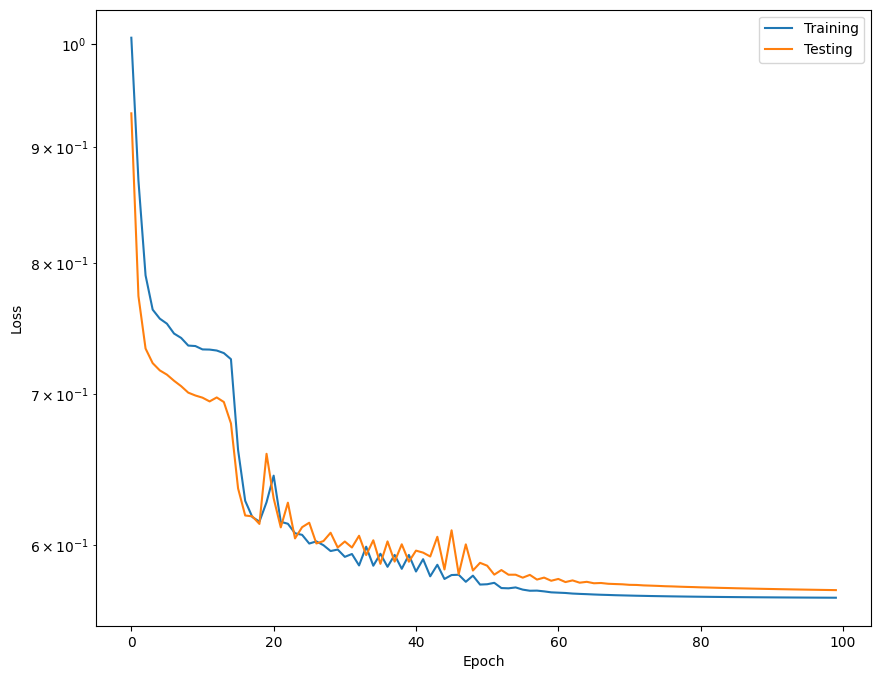

In [76]:
plt.figure(figsize=(10,8))
plt.plot(epoch_nums, training_loss, label='Training')
plt.plot(epoch_nums, testing_loss, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

## Prediction and evaluation

In [77]:
# Make prediction
predictions, num_correct = eval_test(model_cnn, device, test_loader)
predictions = np.concatenate(predictions).ravel()

cnn_accuracy = num_correct / test_imgs.shape[0]

print('{}/{} images in the testing dataset are classified correctly.'.format(num_correct, test_imgs.shape[0]))
print('Testing accuracy of CNN model is:', cnn_accuracy)

239/245 images in the testing dataset are classified correctly.
Testing accuracy of CNN model is: 0.9755102040816327


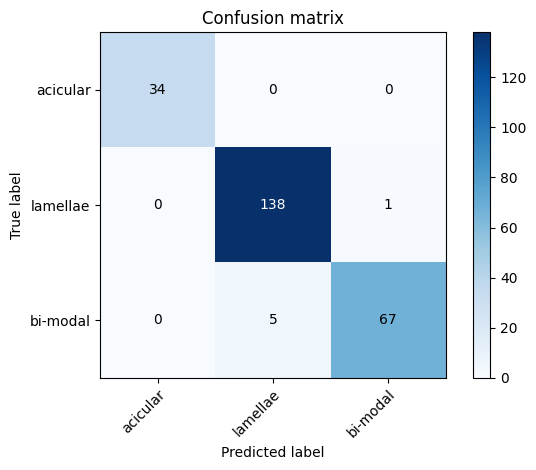

In [78]:
from sklearn.metrics import confusion_matrix

# calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set the tick labels
classes = ['acicular', 'lamellae', 'bi-modal']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion matrix')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

fig.tight_layout()
plt.show()

In [79]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
# Compute precision for each class
precision = precision_score(test_labels, predictions, average=None)

# Print precision for each class
print("Precision for class 0: {:.2f}".format(precision[0]))
print("Precision for class 1: {:.2f}".format(precision[1]))
print("Precision for class 2: {:.2f}".format(precision[2]))

# Compute F1 score for each class
f1 = f1_score(test_labels, predictions, average=None)

# Print F1 score for each class
print("F1 score for class 0: {:.2f}".format(f1[0]))
print("F1 score for class 1: {:.2f}".format(f1[1]))
print("F1 score for class 2: {:.2f}".format(f1[2]))

# Compute recall scores
recall_scores = recall_score(test_labels, predictions, average=None)

# Print recall scores for each class
for i in range(len(recall_scores)):
    print(f"Recall for Class {i}: {recall_scores[i]}")

Precision for class 0: 1.00
Precision for class 1: 0.97
Precision for class 2: 0.99
F1 score for class 0: 1.00
F1 score for class 1: 0.98
F1 score for class 2: 0.96
Recall for Class 0: 1.0
Recall for Class 1: 0.9928057553956835
Recall for Class 2: 0.9305555555555556


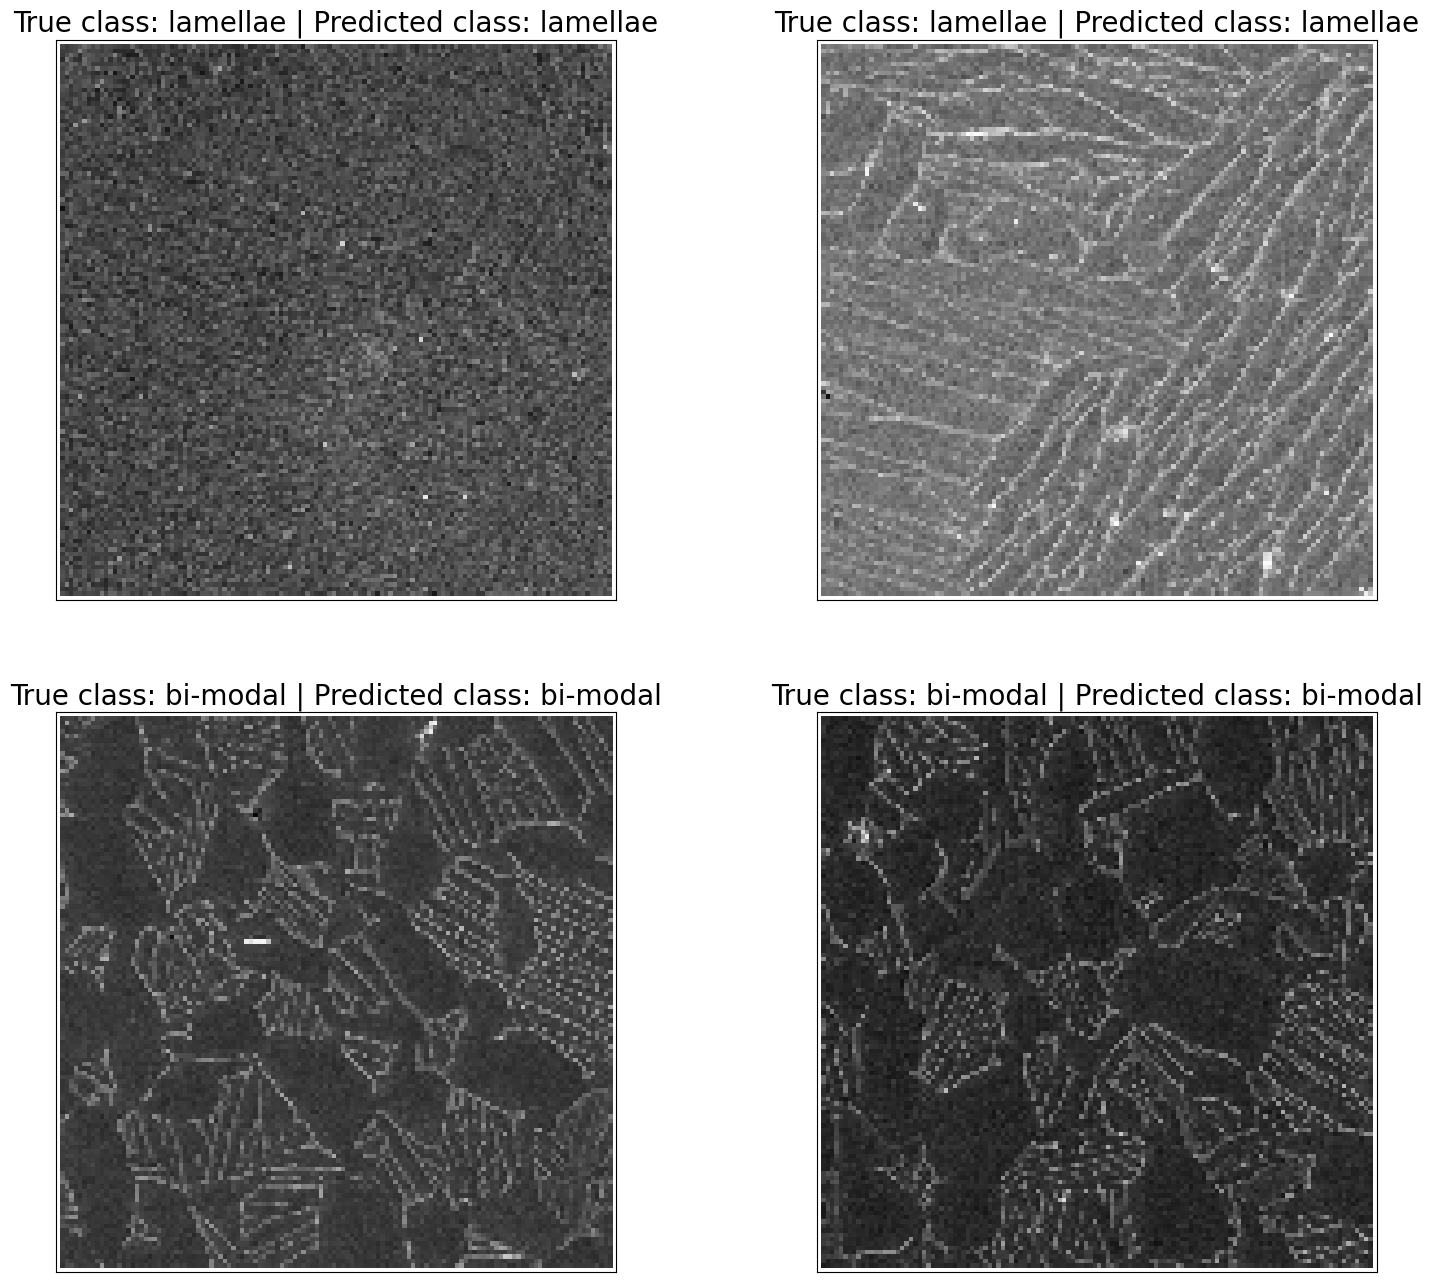

In [80]:
# Visualize correct results
correct_indices = np.nonzero(test_labels == predictions)[0]
plt.figure(figsize=(18, 16))
for j in correct_indices[:4]:
  plt.subplot(2, 2, j+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_imgs[j])
  plt.title('True class: {} | Predicted class: {}'.format(
      cla_list[test_labels[j]], cla_list[predictions[j]]), fontsize=20)
plt.show()

[  7  35  64  72 165 190]


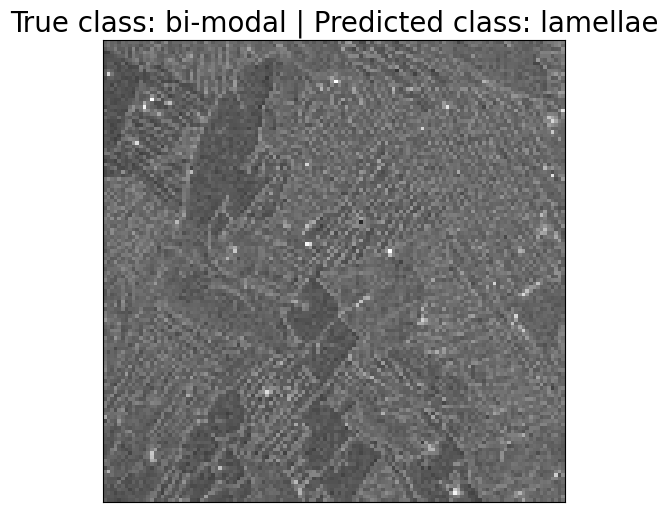

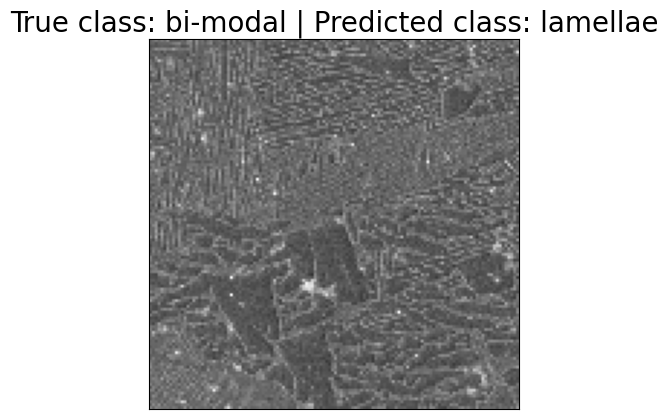

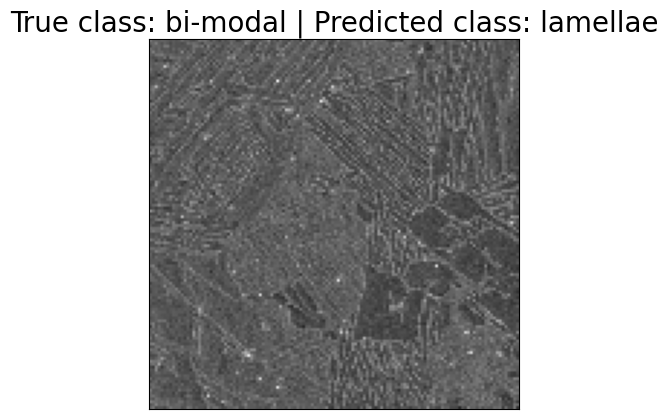

In [81]:
# Visualize incorrect results
# Get the indices of the incorrectly classified images
incorrect_indices = np.nonzero(test_labels != predictions)[0]
print(incorrect_indices)
plt.figure(figsize=(8, 6))
for j in incorrect_indices[0:3]:
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_imgs[j])
  plt.title('True class: {} | Predicted class: {}'.format(
      cla_list[test_labels[j]], cla_list[predictions[j]]), fontsize=20)
  plt.show()

## Visualize the filters

In [82]:
# Access the state_dict of the model
model_state = model_cnn.state_dict()

# Get the filters (kernels) for the first convolutional layer
conv1_filters = model_state['conv1.weight'].cpu().numpy()
print("Shape:", conv1_filters.shape)  # Shape will be (out_channels, in_channels, kernel_size, kernel_size)
print("Conv1 Filters:\n", conv1_filters)

Shape: (16, 3, 3, 3)
Conv1 Filters:
 [[[[ 1.38579890e-01  1.61958024e-01 -5.16419113e-02]
   [ 1.77442923e-01 -4.71222326e-02  3.72916088e-02]
   [-1.08038761e-01  1.12427525e-01  1.65023014e-01]]

  [[-1.49742410e-01  1.69499800e-01  2.94626486e-02]
   [ 1.42839938e-01  2.11079139e-02  9.12540406e-02]
   [-4.15158272e-02  1.47761837e-01  2.38157120e-02]]

  [[-9.83990207e-02  5.12781292e-02 -9.52249318e-02]
   [-2.19130572e-02 -8.31209049e-02  1.26122698e-01]
   [-1.66257888e-01 -8.93165618e-02 -5.89731485e-02]]]


 [[[-1.40292004e-01 -1.03290251e-03 -2.23462477e-01]
   [ 1.64226428e-01 -1.98455200e-01  1.13692656e-01]
   [ 2.78410204e-02 -7.02516288e-02  1.19889058e-01]]

  [[ 5.41618373e-03  1.36295557e-01 -1.23449089e-02]
   [-7.02707991e-02  1.67332161e-02 -8.70726109e-02]
   [ 7.68077374e-02  1.64061591e-01  1.12212144e-01]]

  [[-1.08711161e-01  9.18976963e-02  1.05087040e-03]
   [ 8.81557018e-02 -1.52274266e-01 -2.25391954e-01]
   [-7.85414502e-02 -1.55375749e-01  1.58877403e-0

In [83]:
# Access the state_dict of the model
model_state = model_cnn.state_dict()

# Get the filters (kernels) for the first convolutional layer
conv2_filters = model_state['conv2.weight'].cpu().numpy()
print("Shape:", conv2_filters.shape)  # Shape will be (out_channels, in_channels, kernel_size, kernel_size)
print("Conv2 Filters:\n", conv2_filters)

Shape: (32, 16, 3, 3)
Conv2 Filters:
 [[[[ 0.07149086 -0.07217901 -0.02264182]
   [-0.07315995 -0.07201055  0.00455258]
   [ 0.02973743  0.01509665 -0.03403053]]

  [[ 0.08436523  0.01204024 -0.05226773]
   [ 0.00466319  0.02418793  0.03060903]
   [-0.0502747   0.03509925 -0.04389176]]

  [[ 0.01643122  0.05870523  0.09151871]
   [ 0.14824554  0.17849496  0.09035682]
   [ 0.16349332  0.10696511  0.01742647]]

  ...

  [[-0.05793032 -0.15305549 -0.11470471]
   [-0.06916805 -0.13357592 -0.11476679]
   [-0.08404634 -0.09838913 -0.03000897]]

  [[ 0.09998598 -0.04560031 -0.04451215]
   [ 0.07735913 -0.04403485 -0.04698772]
   [ 0.08954958 -0.06678036  0.00579382]]

  [[ 0.09432381  0.03690056  0.04199447]
   [-0.02892876  0.02802883  0.02779611]
   [ 0.04255241  0.05953775  0.09366027]]]


 [[[-0.07667682 -0.01070477 -0.05483312]
   [-0.07857622 -0.01932519 -0.08593562]
   [ 0.0458845  -0.00323857 -0.05776238]]

  [[ 0.02918776 -0.09353092 -0.04656396]
   [-0.03050817 -0.08492763 -0.067254

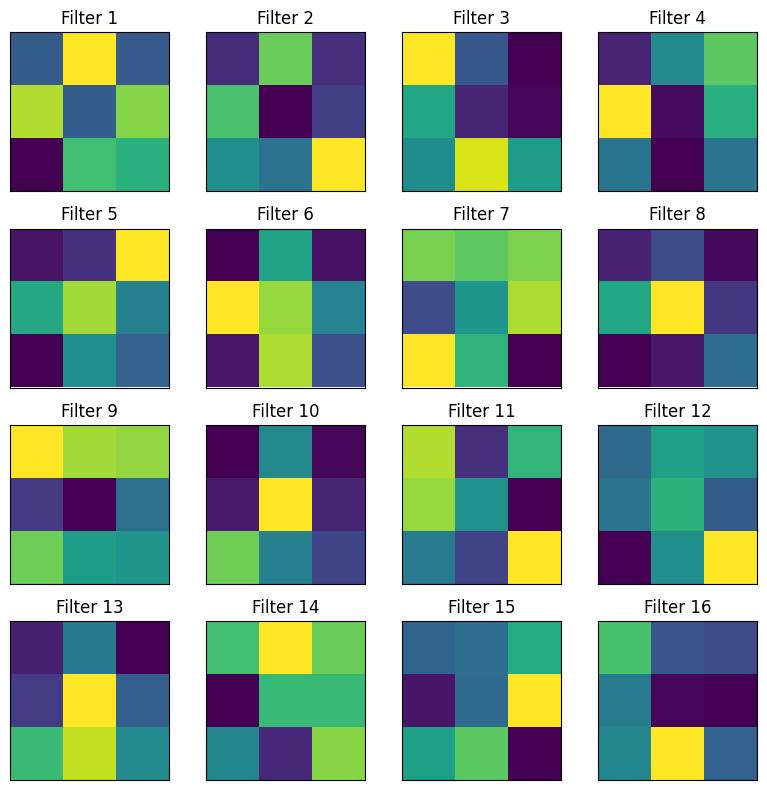

In [84]:
# The following code will create a grid of subplots and display the first convolutional layer's filters 
# as grayscale images. The filters are averaged across all channels (assuming RGB input) for visualization purposes.
def normalize_filter(filter):
    # Normalize filter weights to range [0, 1] for visualization
    min_val = np.min(filter)
    max_val = np.max(filter)
    normalized_filter = (filter - min_val) / (max_val - min_val)
    return normalized_filter

# Get the filters for the first convolutional layer
conv1_filters = model_state['conv1.weight'].cpu().numpy()

# Set up a grid for visualization
num_filters = conv1_filters.shape[0]
num_channels = conv1_filters.shape[1]
grid_size = int(np.ceil(np.sqrt(num_filters)))

# Plot the filters
fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

for idx, ax in enumerate(axes.flat):
    if idx < num_filters:
        # Average the filter weights across all channels (assuming RGB input)
        filter_img = np.mean(normalize_filter(conv1_filters[idx]), axis=0)
        ax.imshow(filter_img)
        ax.set_title(f'Filter {idx+1}')
    else:
        ax.axis('off')
        
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## Visualize the feature maps

In [85]:
# Get one sample image per class from the dataset

# Initialize a list to store one sample image per class
sample_images = [None] * len(cla_list)
# Initialize a set to keep track of found classes
found_classes = set()

# Iterate over batches of images and labels in the training dataset
# (one can also use the test images)
for loader_images, loader_labels in train_loader:
  # Iterate over individual images and labels in the batch
  for image, label in zip(loader_images, loader_labels):
    # Check if the current label has not been found yet
    if label.item() not in found_classes:
      # Store the image in the sample_images list at the index corresponding to the label
      sample_images[label.item()] = image.unsqueeze(0).to(device)
      # Add the label to the set of found_classes
      found_classes.add(label.item())

    # Break the loop if all classes have been found
    if len(found_classes) == len(cla_list):
      break

  # Break the outer loop if all classes have been found
  if len(found_classes) == len(cla_list):
    break


In [86]:
# Define a function to display a single sample image
def show_single_sample_image(img_tensor):
  # Convert the tensor to a NumPy array and transpose axes
  img_np = img_tensor.cpu().numpy().transpose((1, 2, 0))
  # Clip values to the range [0, 1] just in case
  img_np = np.clip(img_np, 0, 1)
  # Display the image
  plt.imshow(img_np)
  # Remove tick marks from the plot
  plt.xticks([])
  plt.yticks([])
  plt.show()

# Define a function to plot feature maps of a given layer
def plot_feature_maps(feature_maps, layer_idx):
  # Extract the feature maps for the specified layer
  layer_feature_maps = feature_maps[layer_idx].cpu().detach().numpy()
  # Determine the number of feature maps and grid size for visualization
  num_feature_maps = layer_feature_maps.shape[1]
  grid_size = int(np.ceil(np.sqrt(num_feature_maps)))

  # Create a grid of subplots for visualization
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

  # Iterate over the feature maps and display them in the grid
  for idx, ax in enumerate(axes.flat):
    if idx < num_feature_maps:
      # Extract the feature map for the current index
      fmap = layer_feature_maps[0, idx, :, :]
      # Display the feature map as an image
      ax.imshow(fmap)
      # Add a title to the subplot with the feature map index
      ax.set_title(f'Feature Map {idx+1}')
    else:
      # Turn off the axis for empty subplots
      ax.axis('off')

    # Remove tick marks from the subplot
    ax.set_xticks([])
    ax.set_yticks([])

  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.suptitle(f'Feature Maps for Layer {layer_idx+1}', y=1.02)
  plt.show()


Sample image from acicular:


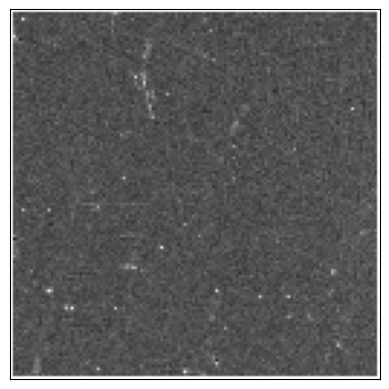

Feature maps for sample image from acicular:


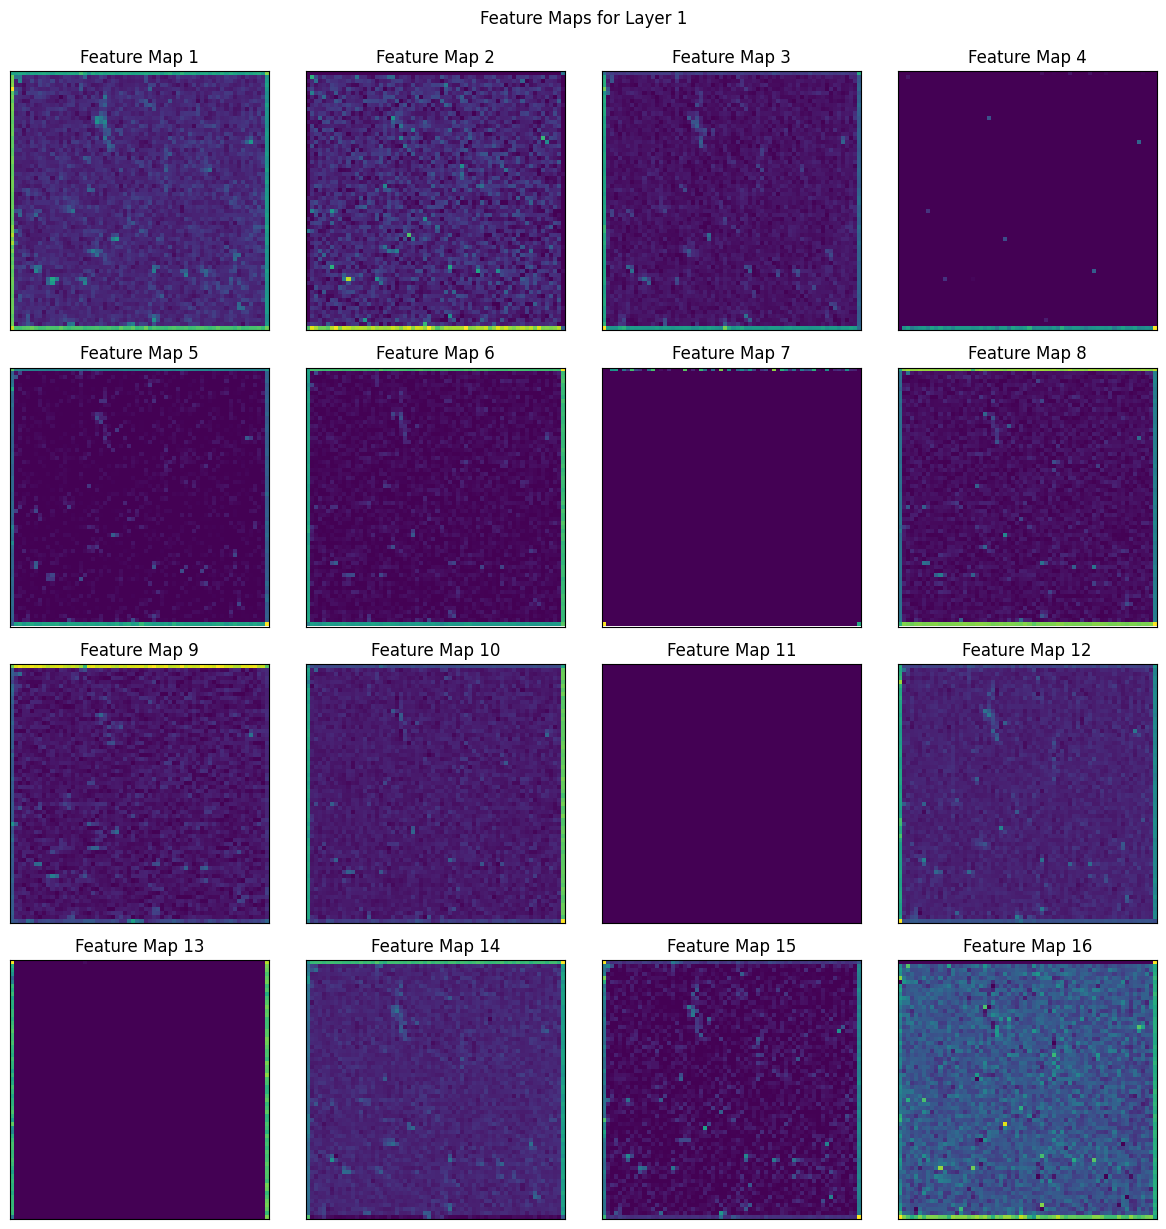

Sample image from lamellae:


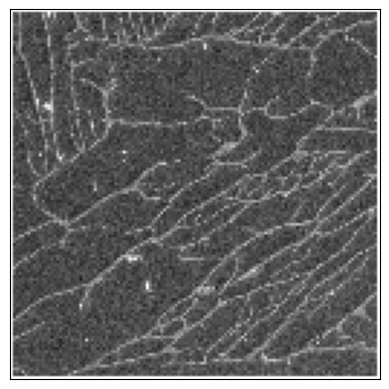

Feature maps for sample image from lamellae:


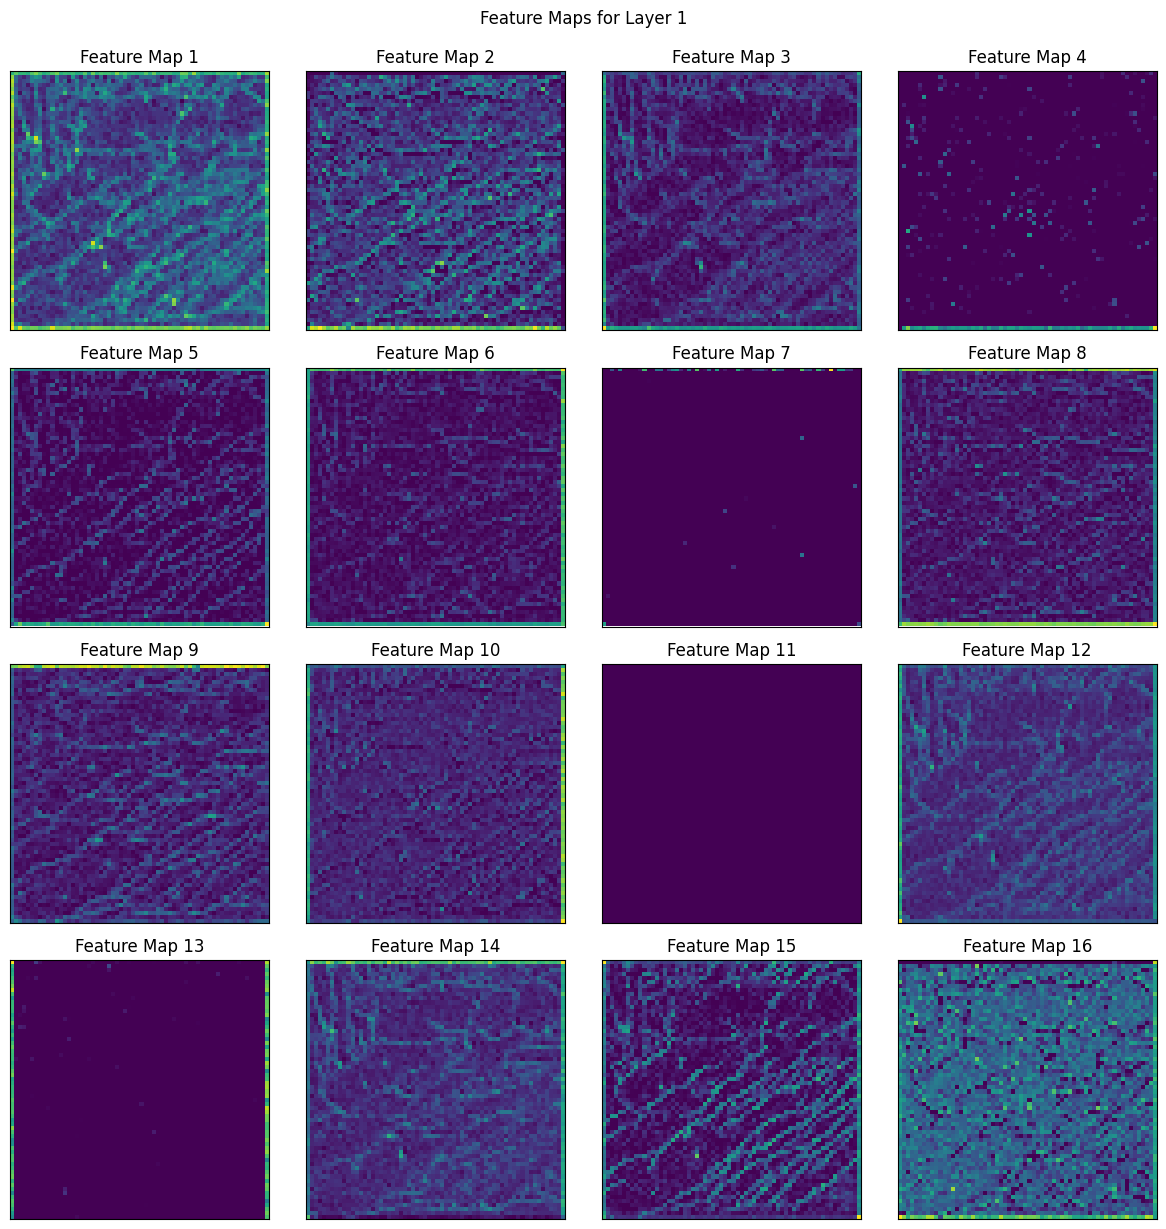

Sample image from bi-modal:


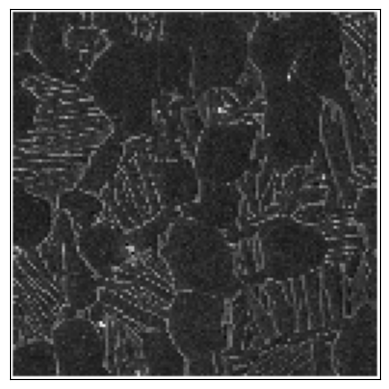

Feature maps for sample image from bi-modal:


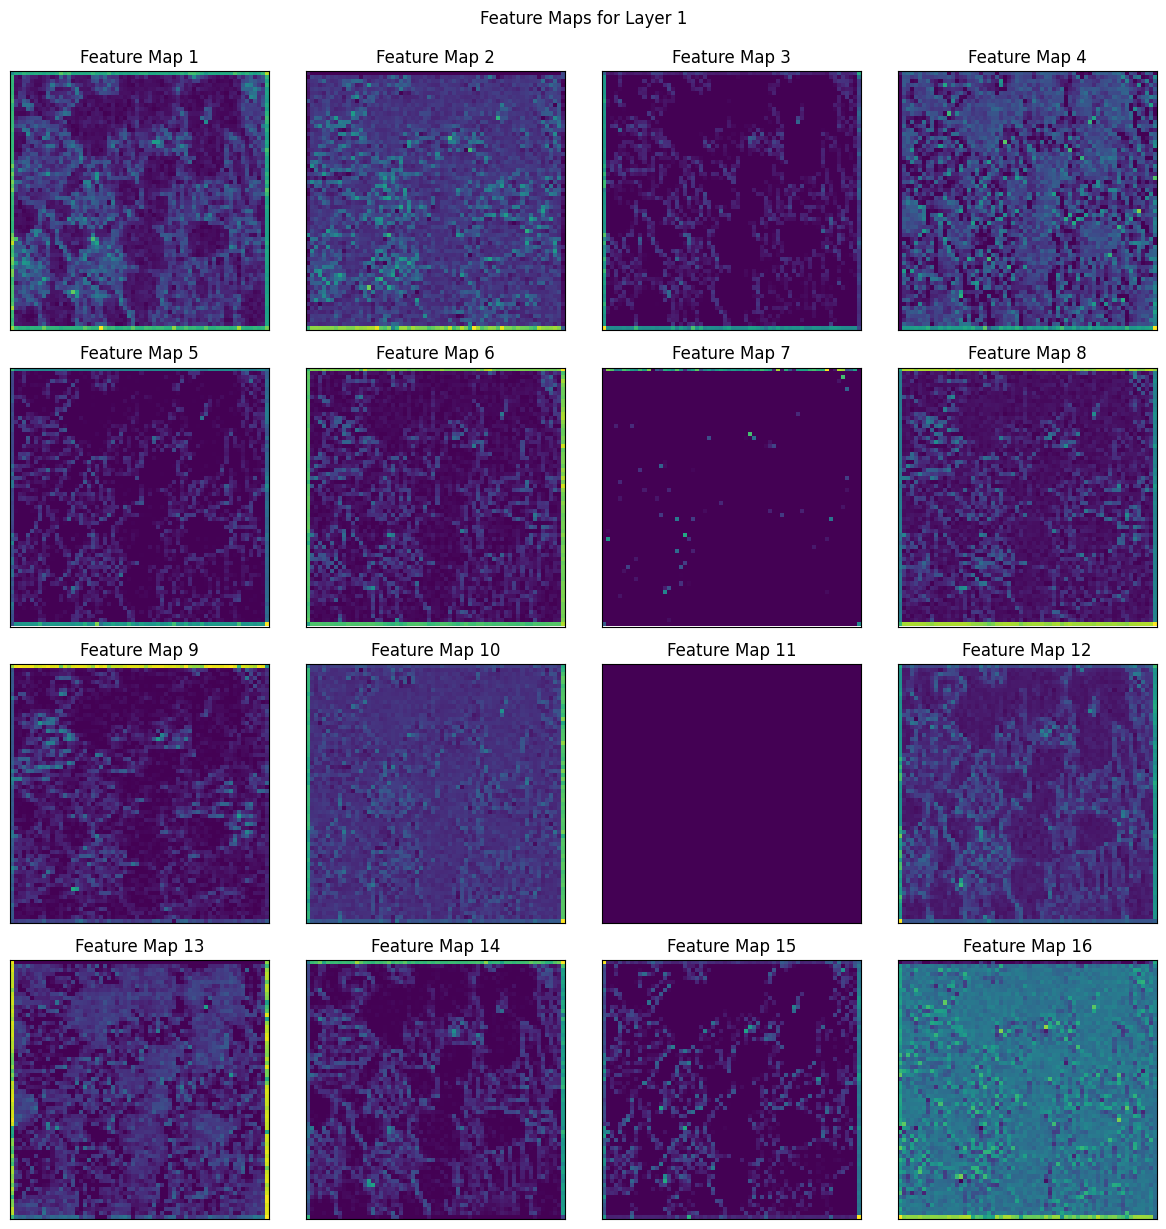

In [87]:
for idx, sample_image in enumerate(sample_images):
  print("Sample image from {}:".format(cla_list[idx]))
  show_single_sample_image(sample_image.squeeze(0))
  _, feature_maps = model_cnn(sample_image, return_feature_maps=True)
  
  print("Feature maps for sample image from {}:".format(cla_list[idx]))
  plot_feature_maps(feature_maps, 0)

Sample image from acicular:


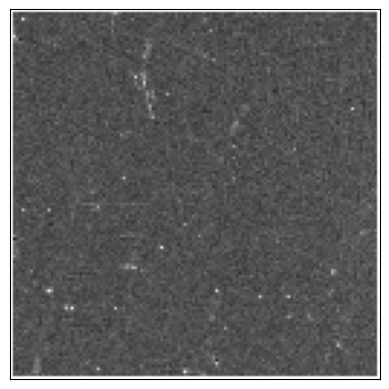

Feature maps for sample image from acicular:


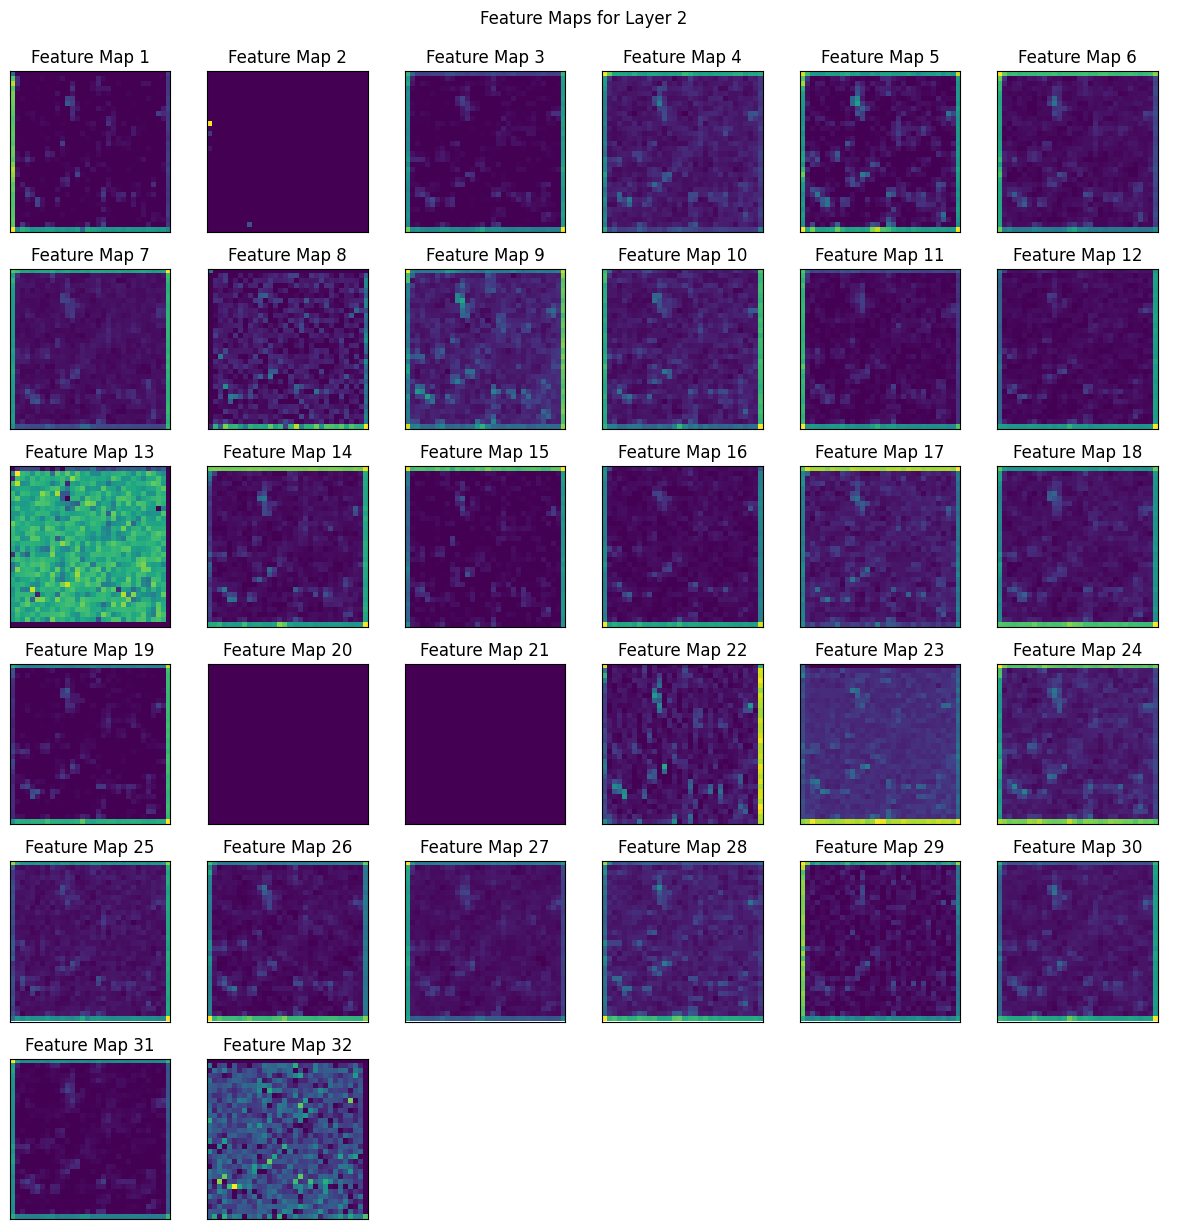

Sample image from lamellae:


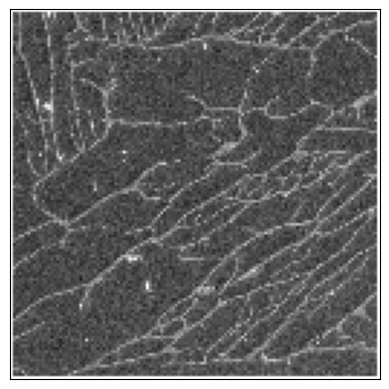

Feature maps for sample image from lamellae:


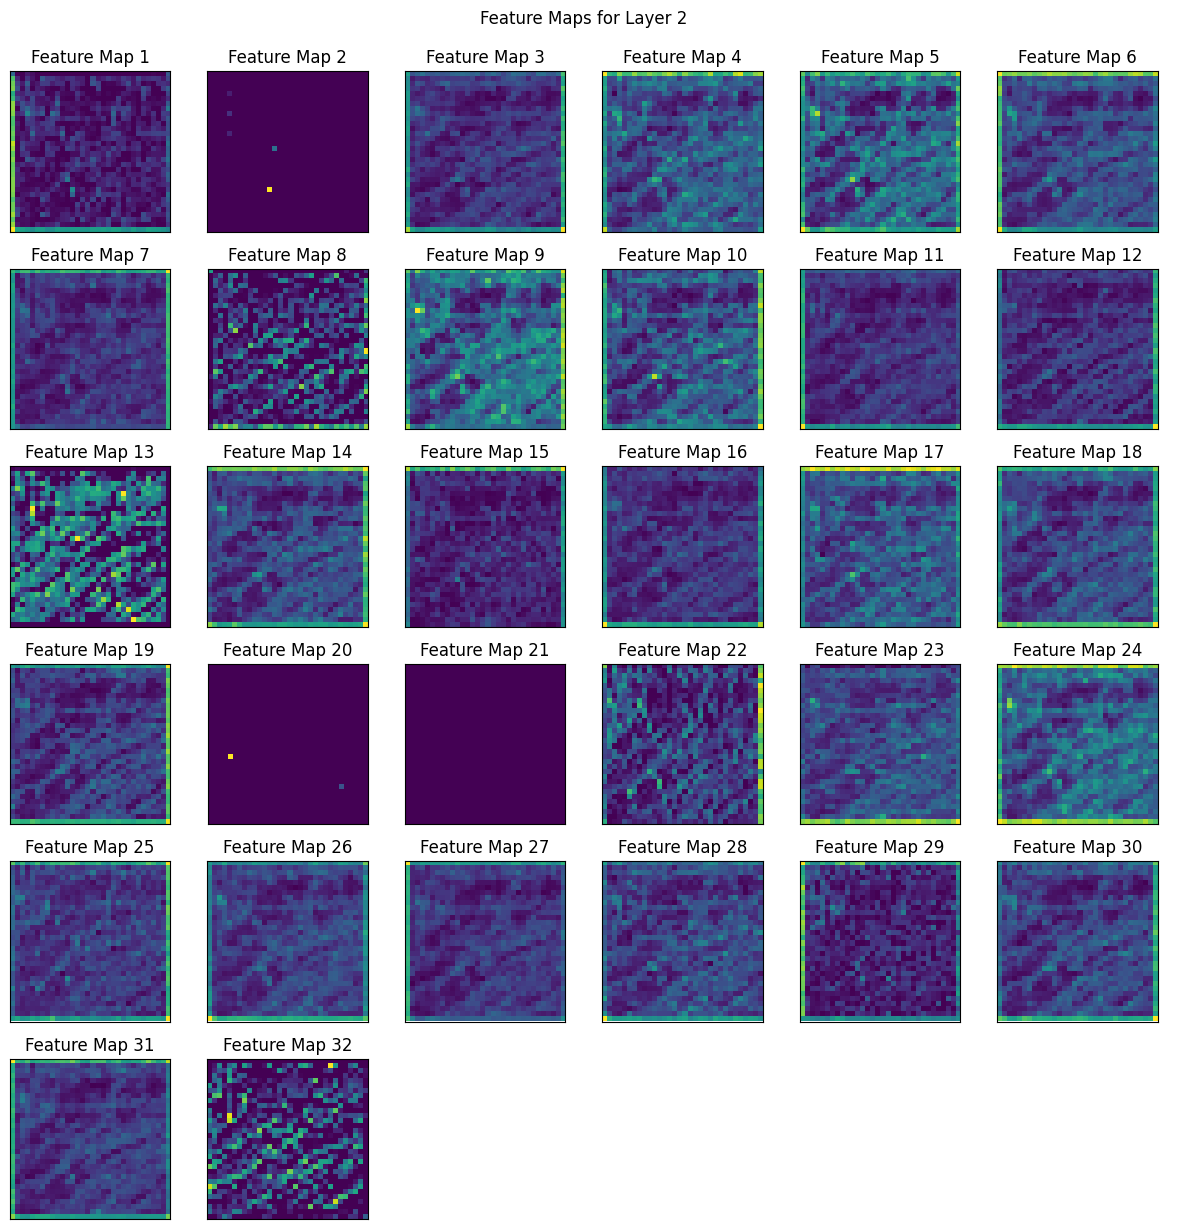

Sample image from bi-modal:


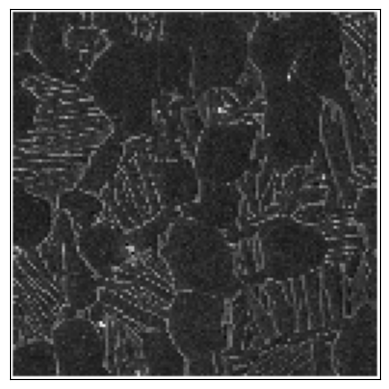

Feature maps for sample image from bi-modal:


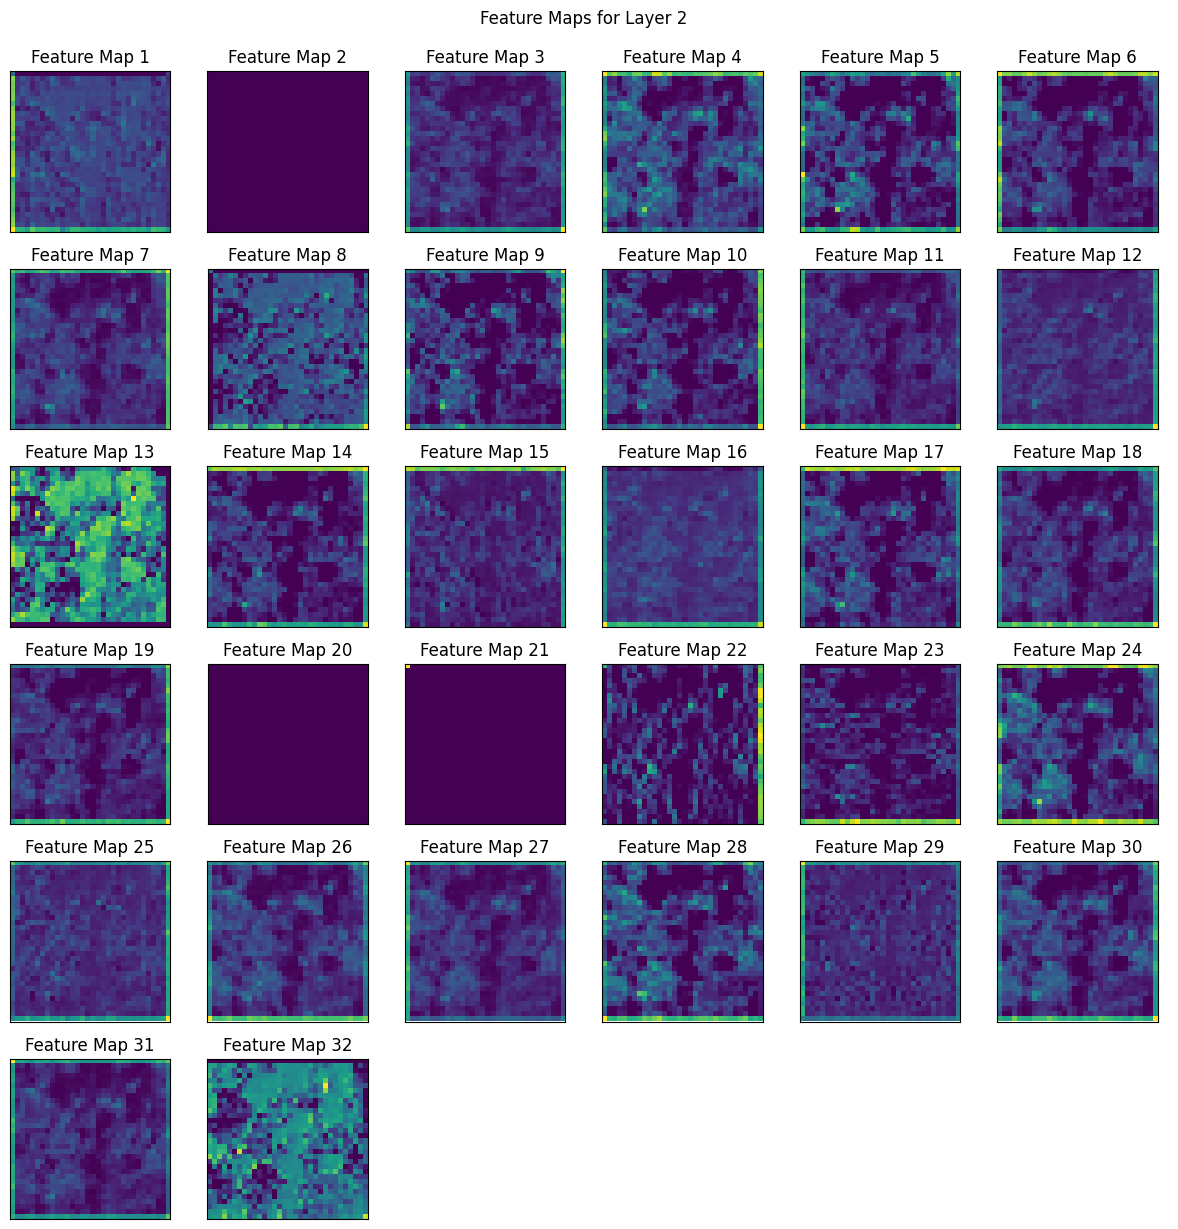

In [88]:
for idx, sample_image in enumerate(sample_images):
  print("Sample image from {}:".format(cla_list[idx]))
  show_single_sample_image(sample_image.squeeze(0))
  _, feature_maps = model_cnn(sample_image, return_feature_maps=True)
  
  print("Feature maps for sample image from {}:".format(cla_list[idx]))
  plot_feature_maps(feature_maps, 1)

In [89]:
# Set the random seed for reproducibility (need to be included to every cell where the random seed is used because each cell in Google Colab runs in a separate session)
seed = 42
torch.manual_seed(seed)

# If GPU is available, set the seed value for it as well
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Build a CNN class
# Build a CNN class
class CNN(nn.Module):
  # Defining the Constructor
  def __init__(self, num_classes):
    super(CNN, self).__init__()
    
    # In the init function, we define each layer we will use in our model
    
    # Our images are RGB, so we have input channels = 3. 
    # We will apply 16 filters in the first convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  
    # A second convolutional layer takes 16 input channels, and generates 32 outputs
    # We in the end apply max pooling with a kernel size of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # We need to flatten these in order to feed them to a fully-connected layer
    self.fc = nn.Linear(in_features=int(dim/4) * int(dim/4) * 32, out_features=num_classes) # dim/4 due to two maxpool with kernel size =2 

  def forward(self, x, return_feature_maps=False):
    # In the forward function, pass the data through the layers we defined in the init function
    # Note: max-pooling and monotonely increasing non-linearities commute. 
    # This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input. 
    # But Relu(MaxPool(x)) is much faster by doing less amount of operations.
    
    # Save the feature maps after each convolutional blocks
    feature_map1 = F.leaky_relu(self.pool1(self.conv1(x)))
    feature_map2 = F.leaky_relu(self.pool2(self.conv2(feature_map1)))

    # Flatten
    x = torch.flatten(feature_map2, 1)

    # Feed to fully-connected layer to predict class
    x = self.fc(x)

    # Return class probabilities via a softmax function
    output = torch.softmax(x, dim=1)


    if return_feature_maps:
      return output, [feature_map1, feature_map2]
    else:
      return output

# Helper function for train, test, and evaluation
def train(model, device, train_loader, optimizer, epoch):
  # Set the model to training mode
  model.train()
  train_loss = 0
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
    # Use the CPU or GPU as appropriate
    # Recall that GPU is optimized for the operations we are dealing with
    data, target = data.to(device), target.to(device)
    # Reset the optimizer
    optimizer.zero_grad()
    # Push the data forward through the model layers
    output = model(data)
    # Get the loss
    loss = loss_criteria(output, target)
    # Keep a running total
    train_loss += loss.item()
    # Backpropagate
    loss.backward()
    optimizer.step()
          
  # return average loss for the epoch
  avg_loss = train_loss / (batch_idx+1)
  return avg_loss

def test(model, device, test_loader):
  # Switch the model to evaluation mode (so we don't backpropagate or drop)
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    batch_count = 0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)
      # Get the predicted classes for this batch
      output = model(data)
      # Calculate the loss for this batch
      test_loss += loss_criteria(output, target).item()
      # Calculate the accuracy for this batch
      _, predicted = torch.max(output.data, 1)
      correct += torch.sum(target==predicted).item()

  # Calculate the average loss and total accuracy for this epoch
  avg_loss = test_loss / batch_count
  
  # return average loss for the epoch
  return avg_loss, correct

def eval_test(model, device, test_loader):
  # Switch the model to evaluation mode (so we don't backpropagate or drop)
  model.eval()

  predictions = []
  num_correct = 0
  with torch.no_grad():
    batch_count = 0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)
      
      # Get the predicted classes for this batch
      output = model(data)
      
      # Calculate the accuracy for this batch
      _, predicted = torch.max(output.data, 1)
      num_correct += torch.sum(target==predicted).item()
      predictions.append(predicted.cpu().numpy().flatten())
          
  return predictions, num_correct

# Create an instance of the model class and allocate it to the device
model_cnn = CNN(num_classes=len(cla_list)).to(device)

print(model_cnn)
print('---'*30)
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
testing_loss = []

print('Training on', device)
num_epoch = 100
pbar = trange(num_epoch) # For processing bar
for epoch in pbar:

  train_loss = train(model_cnn, device, train_loader, optimizer, epoch)
  test_loss, correct = test(model_cnn, device, test_loader)
  
  epoch_nums.append(epoch)
  training_loss.append(train_loss)
  testing_loss.append(test_loss)
  
  pbar.set_postfix({'Train loss': training_loss[-1], 'Test loss': testing_loss[-1], 'Test accuracy': correct / len(test_loader.dataset)})

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32768, out_features=3, bias=True)
)
------------------------------------------------------------------------------------------
Training on cuda


100%|██████████| 100/100 [00:38<00:00,  2.60it/s, Train loss=0.569, Test loss=0.569, Test accuracy=0.98]


In [90]:
# Make prediction
predictions, num_correct = eval_test(model_cnn, device, test_loader)
predictions = np.concatenate(predictions).ravel()

cnn_accuracy = num_correct / test_imgs.shape[0]

print('{}/{} images in the testing dataset are classified correctly.'.format(num_correct, test_imgs.shape[0]))
print('Testing accuracy of CNN model is:', cnn_accuracy)

240/245 images in the testing dataset are classified correctly.
Testing accuracy of CNN model is: 0.9795918367346939


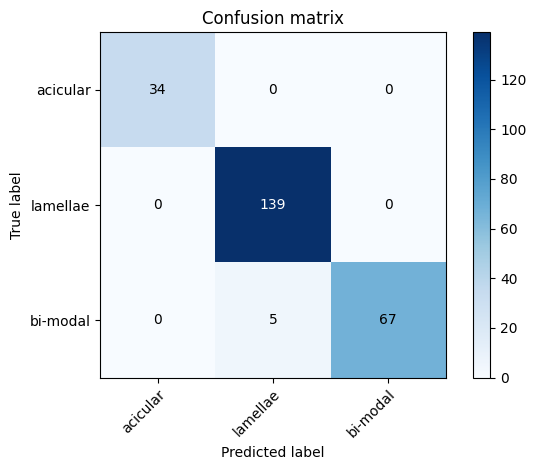

In [91]:
from sklearn.metrics import confusion_matrix

# calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set the tick labels
classes = ['acicular', 'lamellae', 'bi-modal']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion matrix')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

fig.tight_layout()
plt.show()

In [92]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
# Compute precision for each class
precision = precision_score(test_labels, predictions, average=None)

# Print precision for each class
print("Precision for class 0: {:.2f}".format(precision[0]))
print("Precision for class 1: {:.2f}".format(precision[1]))
print("Precision for class 2: {:.2f}".format(precision[2]))

# Compute F1 score for each class
f1 = f1_score(test_labels, predictions, average=None)

# Print F1 score for each class
print("F1 score for class 0: {:.2f}".format(f1[0]))
print("F1 score for class 1: {:.2f}".format(f1[1]))
print("F1 score for class 2: {:.2f}".format(f1[2]))

# Compute recall scores
recall_scores = recall_score(test_labels, predictions, average=None)

# Print recall scores for each class
for i in range(len(recall_scores)):
    print(f"Recall for Class {i}: {recall_scores[i]}")

Precision for class 0: 1.00
Precision for class 1: 0.97
Precision for class 2: 1.00
F1 score for class 0: 1.00
F1 score for class 1: 0.98
F1 score for class 2: 0.96
Recall for Class 0: 1.0
Recall for Class 1: 1.0
Recall for Class 2: 0.9305555555555556


# PCA for dimensionality reduction

MLP(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


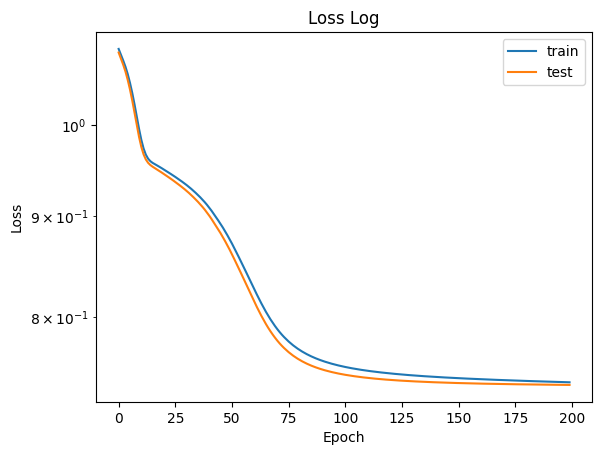

In [93]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*128*128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3*128*128)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x
mlp = MLP()
print(mlp)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

# Train MLP model
train_loss = []
test_loss = []
for epoch in range(200):
    running_train_loss = 0.0
    running_test_loss = 0.0

    # Train the model
    mlp.train()
    for inputs, label in train_loader:
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

# Evaluate the model on the test set
    mlp.eval()
    with torch.no_grad():
        accuracy = 0
        total = 0
        prediction = []
        for inputs, label in test_loader:
            outputs = mlp(inputs)
            loss = criterion(outputs, label)
            running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            prediction.append(predicted)
            total += label.size(0)
            accuracy += (predicted == label).sum().item()
    # Compute and store the average train/test loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)
# Plot the train/test loss
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title("Loss Log")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [94]:
accuracy_mlp = accuracy/test_labels.shape[0]
print("accuracy: ",accuracy/test_labels.shape[0])
predictions = [tensor.tolist() for tensor in prediction]
predictions = sum(predictions, [])
print("MLP predicted:", predictions)

accuracy:  0.8081632653061225
MLP predicted: [2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2]


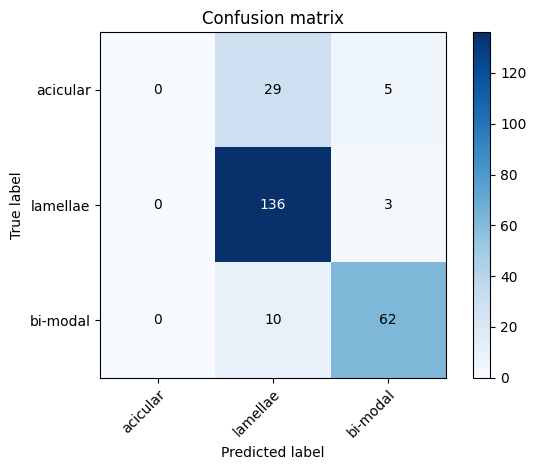

In [95]:
from sklearn.metrics import confusion_matrix
# calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set the tick labels
classes = ['acicular', 'lamellae', 'bi-modal']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion matrix')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

fig.tight_layout()
plt.show()

In [96]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
# Compute precision for each class
precision_mlp = precision_score(test_labels, predictions, average=None)

# Print precision for each class
print("Precision for class 0: {:.2f}".format(precision_mlp[0]))
print("Precision for class 1: {:.2f}".format(precision_mlp[1]))
print("Precision for class 2: {:.2f}".format(precision_mlp[2]))

# Compute F1 score for each class
f1_mlp = f1_score(test_labels, predictions, average=None)

# Print F1 score for each class
print("F1 score for class 0: {:.2f}".format(f1_mlp[0]))
print("F1 score for class 1: {:.2f}".format(f1_mlp[1]))
print("F1 score for class 2: {:.2f}".format(f1_mlp[2]))

# Compute recall scores
recall_scores_mlp = recall_score(test_labels, predictions, average=None)

# Print recall scores for each class
for i in range(len(recall_scores_mlp)):
    print(f"Recall for Class {i}: {recall_scores_mlp[i]}")

Precision for class 0: 0.00
Precision for class 1: 0.78
Precision for class 2: 0.89
F1 score for class 0: 0.00
F1 score for class 1: 0.87
F1 score for class 2: 0.87
Recall for Class 0: 0.0
Recall for Class 1: 0.9784172661870504
Recall for Class 2: 0.8611111111111112


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


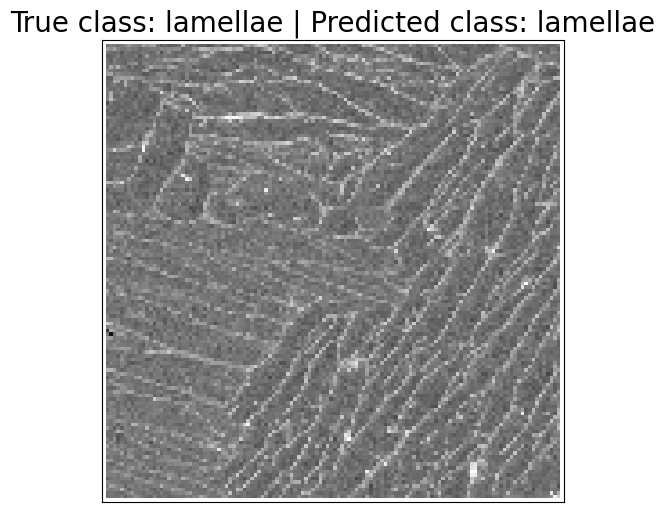

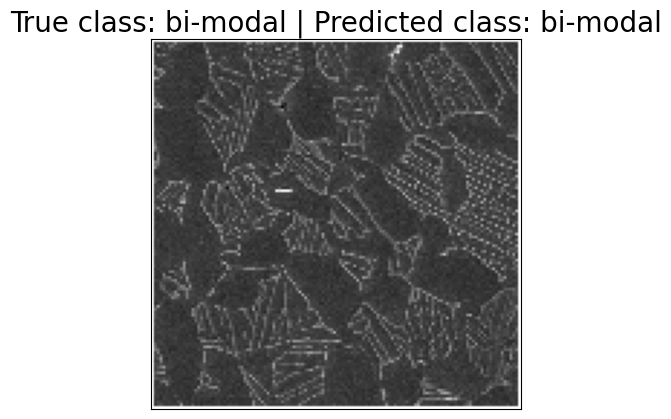

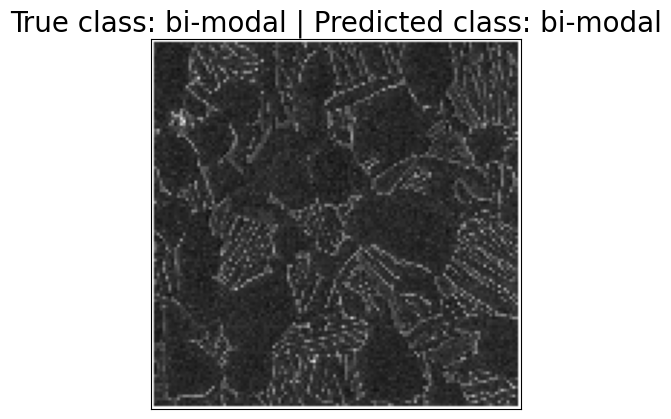

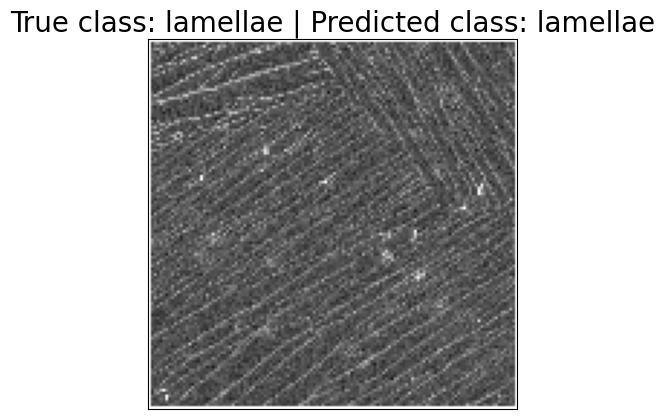

In [97]:
# Visualize correct results
correct_indices = np.nonzero(test_labels == predictions)[0]

plt.figure(figsize=(8, 6))
for j in correct_indices[:4]:
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_imgs[j])
  plt.title('True class: {} | Predicted class: {}'.format(
      cla_list[test_labels[j]], cla_list[predictions[j]]), fontsize=20)
  plt.show()

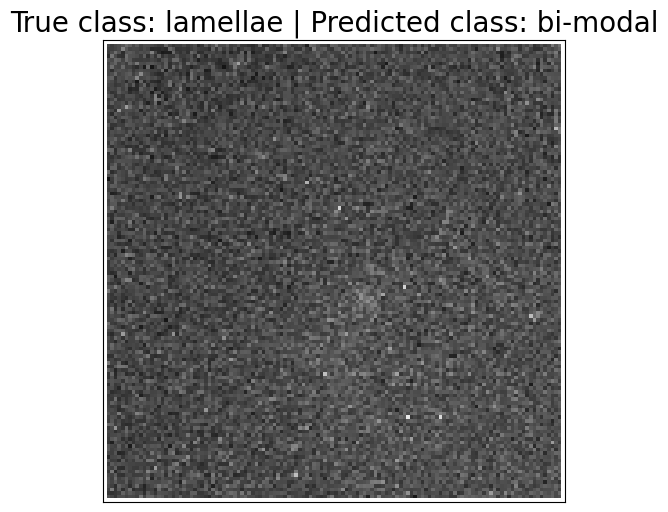

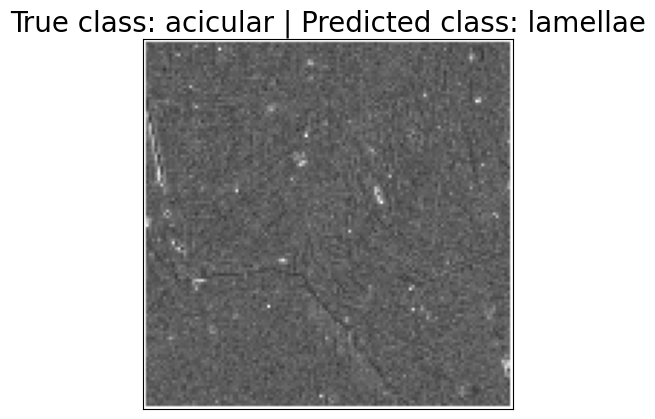

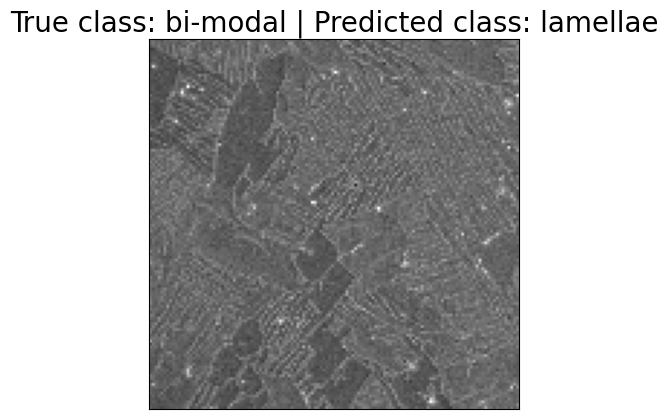

In [98]:
# Visualize incorrect results
# Get the indices of the incorrectly classified images
incorrect_indices = np.nonzero(test_labels != predictions)[0]
plt.figure(figsize=(8, 6))
for j in incorrect_indices[0:3]:
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_imgs[j])
  plt.title('True class: {} | Predicted class: {}'.format(
      cla_list[test_labels[j]], cla_list[predictions[j]]), fontsize=20)
  plt.show()

(1225, 49152)


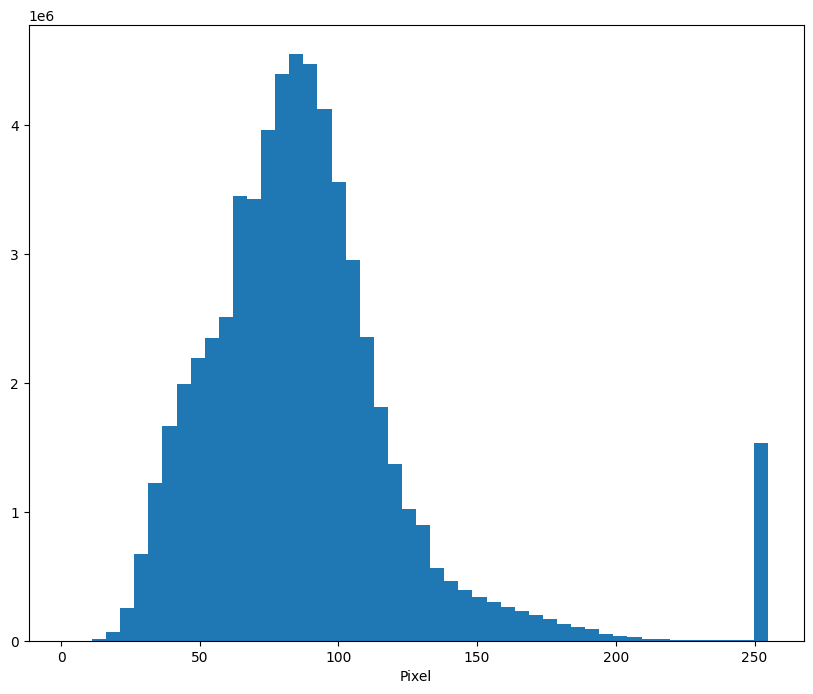

In [99]:
# Flatten the images to 1D array
images_1d = images.reshape(images.shape[0], -1)
print(images_1d.shape)
plt.figure(figsize=(10,8))
plt.hist(images_1d.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()

Before performing PCA:

1. Z-score normalization (**ALWAYS**)

2. Scale the features (**if required, usually suggested**)

PCA is sensitive to the scale of the input features. If features are not standardized, PCA may give undue importance to features with larger numerical ranges, leading to incorrect or biased results. By scaling the data, all features have equal importance during PCA.

Besides, note that the goal of PCA is to maximize the explained variance in the dataset. When features are standardized, their variances are directly comparable, making it easier to identify and retain the principal components that capture the most variance.

There are some other advantages of performing feature scaling before using PCA such as numerical stability and faster convergence as we mentioned in the course.

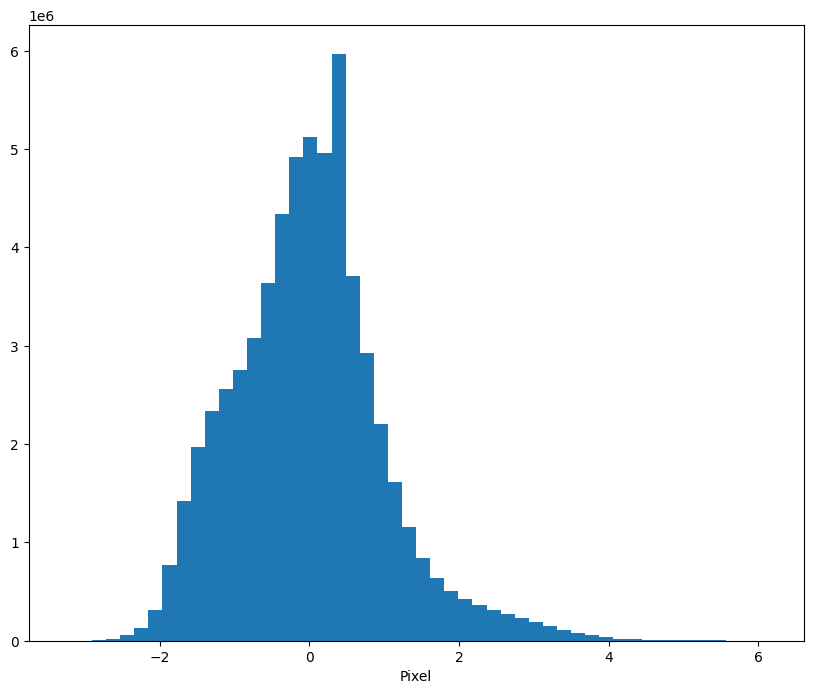

In [100]:
# Perform Z-score normalization
images_1d_n = (images_1d - images_1d.mean(axis=0)) / images_1d.std(axis=0)
plt.figure(figsize=(10,8))
plt.hist(images_1d_n.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()

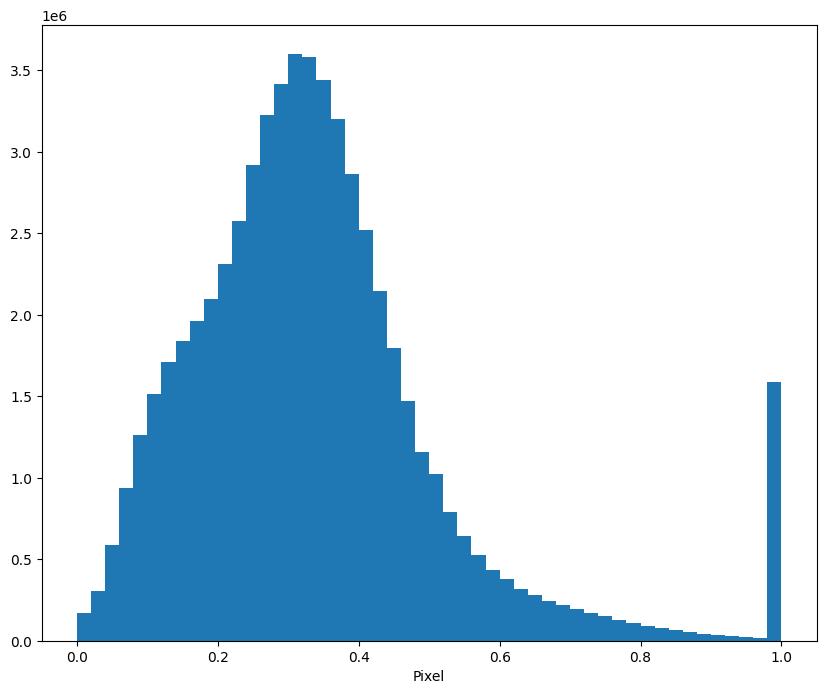

In [101]:
# Perform MinMax rescaling
images_1d_ns = (images_1d_n - images_1d_n.min(axis=0)) / (images_1d_n.max(axis=0) - images_1d_n.min(axis=0))

plt.figure(figsize=(10,8))
plt.hist(images_1d_ns.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()

Documentation for PCA from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [102]:
n_pca = 100 # Number of pincipal components to keep
# Perform PCA
pca_100 = PCA(n_components=n_pca, random_state=0)
images_pca_100 = pca_100.fit_transform(images_1d_ns)
print('Shape of the obtained principal components', images_pca_100.shape)


Shape of the obtained principal components (1225, 100)


In [103]:
# Print a sample of the principal component values
print("Sample of the first 10 principal component values:\n", images_pca_100[:10,:10])

Sample of the first 10 principal component values:
 [[ 2.87054503e+00 -5.82341154e+00 -3.54861754e-01  2.81885637e-02
  -1.01161133e-01  3.90938309e-02 -1.73500419e-01  1.96232536e-02
  -2.18539233e-01  1.10496766e-01]
 [ 3.43199003e+01 -9.16646290e+00  3.11568884e+00 -1.12303388e+00
  -9.41270143e-02  1.52989554e-01 -7.18344082e-02 -1.26232856e-01
   3.83771098e-01 -1.04683206e-01]
 [-3.87460371e+00 -5.10089320e+00  2.25209778e-01  1.05966842e-01
  -2.78589606e-01  1.57100985e-01  1.12627244e-01  1.32830946e-01
  -6.85877947e-02 -1.53887373e-01]
 [ 8.19089297e+00 -6.38730999e+00  3.52984407e-01 -2.76533900e-01
   1.52279808e-01  1.30949275e-01  2.05741698e-01  4.76946583e-02
  -5.34941582e-02 -1.18665870e-01]
 [-5.99980664e+00 -4.88790997e+00 -8.19962527e-01  4.68012242e-01
  -5.07422721e-03 -2.51303855e-01 -3.67361862e-02 -2.41915504e-02
  -1.84236141e-02 -1.40237377e-01]
 [-1.07608539e+01 -4.36709806e+00 -2.10258465e-01 -1.40194954e-01
   4.71960710e-01  8.31896473e-02  1.56360401e-

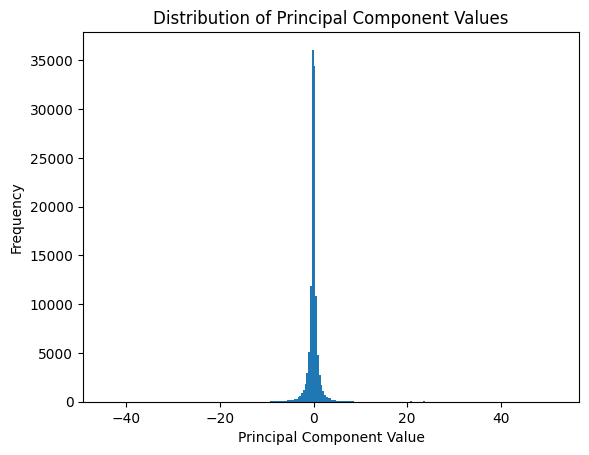

In [104]:
# Plot a histogram of the distribution of principal component values
plt.hist(images_pca_100.flatten(), bins=256)
plt.title("Distribution of Principal Component Values")
plt.xlabel("Principal Component Value")
plt.ylabel("Frequency")
plt.show()

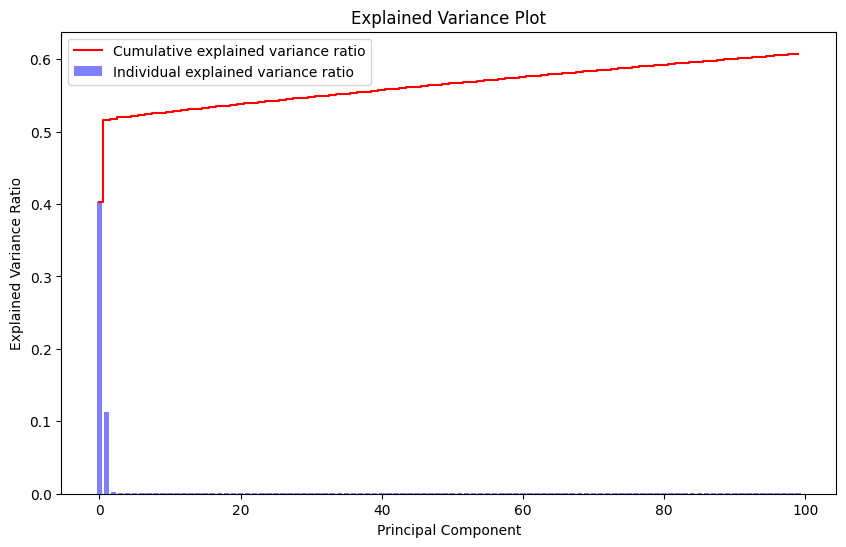

In [105]:
explained_variance_ratio = pca_100.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(n_pca), explained_variance_ratio, alpha=0.5, color='blue', label='Individual explained variance ratio')
plt.step(range(n_pca), cumulative_explained_variance_ratio, where='mid', color='red', label='Cumulative explained variance ratio')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Plot')
plt.legend(loc='best')
plt.show()

The first two principal components are the most important and useful.

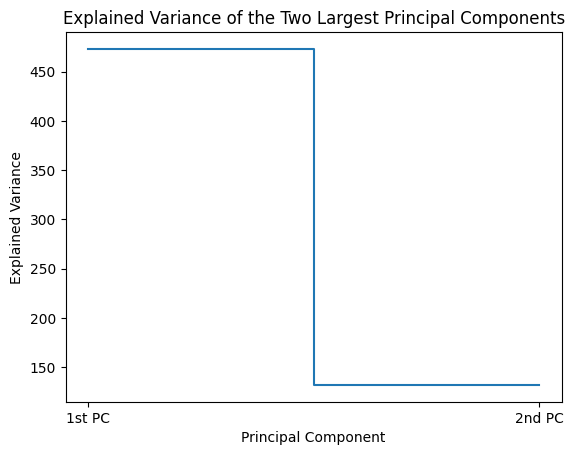

In [106]:
# Perform PCA with 2 components
pca_2 = PCA(n_components=2)
X_pca_100 = pca_100.fit_transform(images_1d_ns)
X_pca_2 = pca_2.fit_transform(images_1d_ns)
# Calculate the explained variance of the two largest principal components
explained_variance = pca_2.explained_variance_

# Plot the individual explained variance of the two largest principal components
plt.step([1, 2], explained_variance, where='mid')
plt.xticks([1, 2], ['1st PC', '2nd PC'])
plt.title("Explained Variance of the Two Largest Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.show()

The **explained variance plot** is a visualization that illustrates the proportion of the total variance in the dataset that is explained or captured by each principal component. 

There are two key elements in the explained variance plot:

* **Individual explained variance ratio:** This is represented by the height of each bar in the bar plot. It indicates the proportion of the total variance explained by a specific principal component. A higher bar means that the corresponding principal component captures more variance and is thus more informative. The individual explained variance is calculated as the ratio of the eigenvalue for a specific principal component to the sum of all eigenvalues.

* **Cumulative explained variance ratio:** This is represented by the step plot, which shows the cumulative sum of the explained variance as you add more principal components. The cumulative explained variance helps us understand how much of the total variance is captured by a certain number of principal components. For example, if the cumulative explained variance reaches 95% at the 50th principal component, it means that 95% of the total variance in the data can be explained by the first 50 principal components.

The explained variance plot is useful for understanding the importance of each principal component and determining the optimal number of components to retain. In practice, we may want to keep enough principal components to capture a significant proportion of the total variance (e.g., 90%, 95%, or 99%) without retaining all the components, which can help reduce the dimensionality and complexity of our data or model.

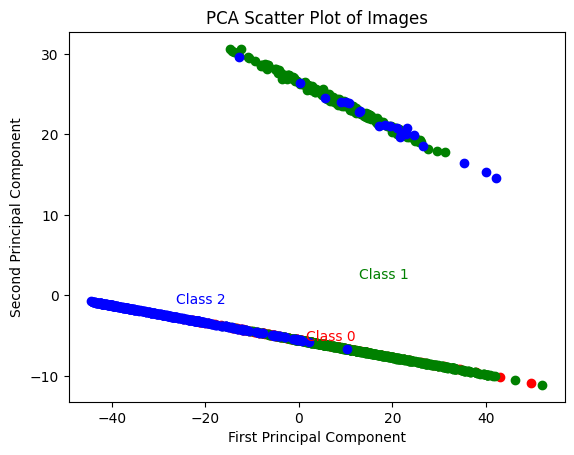

In [107]:
# Create a scatter plot of the first two principal components
colors = ['r', 'g', 'b']
# Plot the scatter plot
for i in range(len(colors)):
    plt.scatter(X_pca_2[labels==i, 0], X_pca_2[labels==i, 1], c=colors[i], label=f'Class {i}')
    plt.text(np.mean(X_pca_2[labels==i, 0]), np.mean(X_pca_2[labels==i, 1]), f'Class {i}',color=colors[i])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Scatter Plot of Images')
plt.show()

The clustering of images in this plot reveals how well the PCA has separated the images into different groups based on their features. Specifically, we can see that images from the same class tend to cluster together in the plot, indicating that they share similar feature representations in the first two principal components.
Additionally, we can observe some overlap between the clusters, which indicates that some images from different classes may share similar feature representations in the first two principal components. 

In [108]:
train_imgs_pca_2, test_imgs_pca_2, train_labels_pca_2, test_labels_pca_2 = train_test_split(X_pca_2, labels, test_size=0.2, random_state=42)
print('Training set has {} images.'.format(train_imgs.shape[0]))
print('Testing set has {} images.'.format(test_imgs.shape[0]))

Training set has 980 images.
Testing set has 245 images.


In [109]:
train_imgs_pca, test_imgs_pca, train_labels_pca, test_labels_pca = train_test_split(X_pca_100, labels, test_size=0.2, random_state=42)
print('Training set has {} images.'.format(train_imgs.shape[0]))
print('Testing set has {} images.'.format(test_imgs.shape[0]))

Training set has 980 images.
Testing set has 245 images.


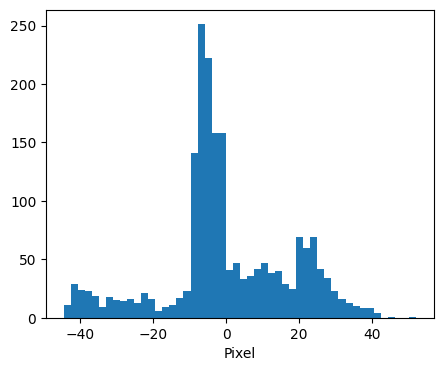

In [110]:
plt.figure(figsize=(5,4))
plt.hist(train_imgs_pca_2.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()

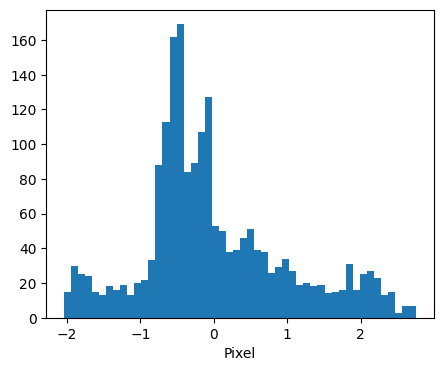

In [111]:
# Perform Z-score normalization
images_train_pca2_n = (train_imgs_pca_2 - train_imgs_pca_2.mean(axis=0)) / train_imgs_pca_2.std(axis=0)
images_test_pca2_n = (test_imgs_pca_2 - train_imgs_pca_2.mean(axis=0)) / train_imgs_pca_2.std(axis=0)
plt.figure(figsize=(5,4))
plt.hist(images_train_pca2_n.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()


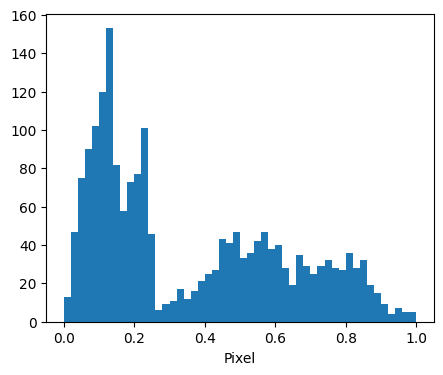

In [112]:
# Perform MinMax rescaling
images_train_pca2_ns = (images_train_pca2_n - images_train_pca2_n.min(axis=0)) / (images_train_pca2_n.max(axis=0) - images_train_pca2_n.min(axis=0))
images_test_pca2_ns = (images_test_pca2_n - images_train_pca2_n.min(axis=0)) / (images_train_pca2_n.max(axis=0) - images_train_pca2_n.min(axis=0))
plt.figure(figsize=(5,4))
plt.hist(images_train_pca2_ns.ravel(), bins=50)
plt.xlabel('Pixel')
plt.show()


In [113]:
# Perform Z-score normalization
images_train_pca_n = (train_imgs_pca - train_imgs_pca.mean(axis=0)) / train_imgs_pca.std(axis=0)
images_test_pca_n = (test_imgs_pca - train_imgs_pca.mean(axis=0)) / train_imgs_pca.std(axis=0)
# Perform MinMax rescaling
images_train_pca_ns = (images_train_pca_n - images_train_pca_n.min(axis=0)) / (images_train_pca_n.max(axis=0) - images_train_pca_n.min(axis=0))
images_test_pca_ns = (images_test_pca_n - images_train_pca_n.min(axis=0)) / (images_train_pca_n.max(axis=0) - images_train_pca_n.min(axis=0))

In [114]:
print(images_train_pca_n )

[[ 0.09811996 -0.48635314  2.2780382  ... -2.52935448 -1.60278395
  -1.1506554 ]
 [ 0.57723087 -0.58684853 -0.13879346 ... -3.4111776   2.90139281
   0.28590579]
 [-1.61887898 -0.13494601  0.15961861 ... -0.45869105  0.05300007
   0.28164402]
 ...
 [-1.38309239 -0.18163037 -0.34493145 ... -0.30804824  0.74884031
   0.26456287]
 [ 1.44784229 -0.76774525 -0.00536482 ... -0.42610741  0.16852391
  -0.76188929]
 [-1.78649122 -0.0967898  -0.2508165  ... -0.01328315 -0.30311511
  -0.1310239 ]]


Test accuracy for pca100+MLP: 0.8041


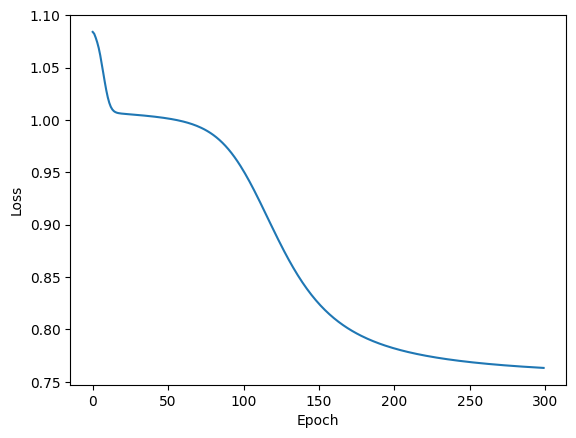

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = nn.functional.softmax(self.fc3(x), dim=1)
        return x

mlp_model = MLP()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Train the model
num_epochs = 300
batch_size = 200
num_batches = int(np.ceil(images_train_pca_ns.shape[0] / batch_size))

loss_history = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = torch.from_numpy(images_train_pca_ns[start_idx:end_idx]).float()
        y_batch = torch.from_numpy(train_labels_pca[start_idx:end_idx])
        
        optimizer.zero_grad()
        
        outputs = mlp_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(images_train_pca_ns)
    loss_history.append(epoch_loss)
        
    
# Evaluate the model
X_test_pca_tensor = torch.from_numpy(images_test_pca_ns).float()
y_pred = torch.argmax(mlp_model(X_test_pca_tensor), dim=1)
accuracy_100_mlp = (torch.sum(y_pred == torch.from_numpy(test_labels_pca)) / test_labels_pca.shape[0]).tolist()
print(f'Test accuracy for pca100+MLP: {accuracy_100_mlp:.4f}')

plt.plot(range(num_epochs), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

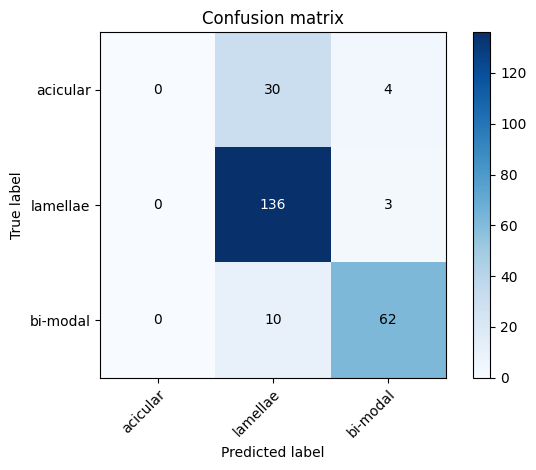

In [117]:
from sklearn.metrics import confusion_matrix
# calculate the confusion matrix
predictions = y_pred.tolist()
cm = confusion_matrix(test_labels_pca, predictions)

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set the tick labels
classes = ['acicular', 'lamellae', 'bi-modal']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion matrix')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

fig.tight_layout()
plt.show()

In [118]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
# Compute precision for each class
precision_mlp = precision_score(test_labels, predictions, average=None)

# Print precision for each class
print("Precision for class 0: {:.2f}".format(precision_mlp[0]))
print("Precision for class 1: {:.2f}".format(precision_mlp[1]))
print("Precision for class 2: {:.2f}".format(precision_mlp[2]))

# Compute F1 score for each class
f1_mlp = f1_score(test_labels, predictions, average=None)

# Print F1 score for each class
print("F1 score for class 0: {:.2f}".format(f1_mlp[0]))
print("F1 score for class 1: {:.2f}".format(f1_mlp[1]))
print("F1 score for class 2: {:.2f}".format(f1_mlp[2]))

# Compute recall scores
recall_scores_mlp = recall_score(test_labels, predictions, average=None)

# Print recall scores for each class
for i in range(len(recall_scores_mlp)):
    print(f"Recall for Class {i}: {recall_scores_mlp[i]}")

Precision for class 0: 0.00
Precision for class 1: 0.77
Precision for class 2: 0.90
F1 score for class 0: 0.00
F1 score for class 1: 0.86
F1 score for class 2: 0.88
Recall for Class 0: 0.0
Recall for Class 1: 0.9784172661870504
Recall for Class 2: 0.8611111111111112


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [192]:
#2.3
svm_rbf = SVC( kernel='rbf' )
svm_rbf.fit( images_train_pca_ns, train_labels_pca )
# Get the predictions on the test set
y_pred = svm_rbf.predict(images_test_pca_ns)
print(y_pred)
print('SVM rbf kernel training score: ', svm_rbf.score(images_train_pca_ns, train_labels_pca))
accuracy_100_svm = svm_rbf.score(images_test_pca_ns, test_labels_pca)
print('SVM rbf kernel testing score: ', svm_rbf.score(images_test_pca_ns, test_labels_pca))

[0 1 2 2 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 2 1 0 0 1 1 1 1 1 1 1 2 1 2 1 1 1 1
 2 1 2 1 1 0 1 2 0 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 0 1 1 1 2 0 1 0 2 1 1 0
 0 1 0 1 2 0 2 2 1 0 1 2 1 1 1 2 1 1 0 0 0 2 1 1 1 1 2 1 0 2 2 1 1 0 0 2 1
 0 2 2 1 1 2 1 1 1 1 0 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 0 1 1 1 0 1 2 1 1 2 1 2 2 1 0 1 1 0 1 0 1 1 2 2 0 0 1 1 2 1 1 1 1 1 1
 1 1 2 1 0 2 1 0 1 2 0 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 2 1 1 1 0 1 1
 2 1 2 2 2 2 1 1 1 2 0 1 1 2 1 2 1 2 0 1 1 2 2]
SVM rbf kernel training score:  0.9275510204081633
SVM rbf kernel testing score:  0.9061224489795918


In [193]:
#2.4
rforest = RandomForestClassifier( random_state = 42 )
rforest.fit(images_train_pca_ns, train_labels_pca )
y_pred = rforest.predict(images_test_pca_ns)
print(y_pred)
print( 'Random forest training score: ', rforest.score(images_train_pca_ns, train_labels_pca) )
accuracy_100_RF = rforest.score(images_test_pca_ns, test_labels_pca)
print( 'Random forest testing score: ', rforest.score(images_test_pca_ns, test_labels_pca) )

[1 1 2 2 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 2 1 0 0 1 1 2 1 1 1 1 2 1 2 2 1 1 1
 2 1 2 1 0 0 1 2 0 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 0 2 1 1 1
 0 1 0 1 2 0 2 2 1 0 1 2 1 1 1 2 1 1 0 0 0 2 1 1 1 2 2 1 2 2 2 1 1 0 0 2 1
 0 2 2 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 1 1 1 1 0 1 2 1 1 2 1 2 2 1 1 1 1 0 1 0 1 1 2 2 0 0 1 1 2 1 1 1 1 1 1
 1 1 2 1 0 2 1 0 1 2 0 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 0 1 1
 2 0 2 2 2 2 1 1 1 2 0 1 1 2 1 2 1 2 1 1 1 2 2]
Random forest training score:  1.0
Random forest testing score:  0.9387755102040817


In [194]:
#2.5
svm_rbf = SVC( kernel='rbf' )
svm_rbf.fit( images_train_pca2_ns, train_labels_pca )
y_pred = svm_rbf.predict(images_test_pca2_ns)
print(y_pred)
accuracy_2_svm = svm_rbf.score(images_test_pca2_ns, test_labels_pca)
print( 'SVM rbf kernel training score: ', svm_rbf.score(images_train_pca2_ns, train_labels_pca))
print( 'SVM rbf kernel testing score: ', svm_rbf.score(images_test_pca2_ns, test_labels_pca) )

[0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 0 2 1 1 1
 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1
 1 1 1 1 2 1 2 2 1 0 1 2 1 1 1 2 1 1 1 0 1 2 1 1 1 2 2 1 0 2 2 1 1 0 2 2 1
 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 1 1 1 1 1 1 2 1 1 2 1 2 2 1 0 1 1 1 1 1 1 1 2 2 0 1 1 1 2 1 1 1 1 1 1
 1 1 2 1 0 2 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 0 1 2 1 1 1 1 1 1
 2 1 2 2 2 2 1 1 1 2 1 1 1 2 1 2 1 2 1 1 1 2 2]
SVM rbf kernel training score:  0.8173469387755102
SVM rbf kernel testing score:  0.8163265306122449


In [195]:
rforest = RandomForestClassifier( random_state = 42 )
rforest.fit(images_train_pca2_ns, train_labels_pca )
y_pred = rforest.predict(images_test_pca2_ns)
print(y_pred)
print( 'Random forest training score: ', rforest.score(images_train_pca2_ns, train_labels_pca) )
accuracy_2_RF = rforest.score(images_test_pca2_ns, test_labels_pca)
print( 'Random forest testing score: ', rforest.score(images_test_pca2_ns, test_labels_pca) )

[0 1 2 2 1 1 2 1 1 0 1 1 1 1 2 1 1 1 1 2 1 0 1 1 1 2 1 1 1 1 2 1 2 2 1 1 1
 2 1 2 1 1 1 1 2 1 1 1 1 1 1 0 1 2 1 1 1 2 1 1 1 1 0 1 1 1 2 0 1 0 2 1 1 0
 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 2 2 1 0 2 0 1 1 2 2 2 1
 1 2 2 1 1 2 1 1 1 1 0 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 0 1 2 2 1 1 1 2 2
 1 1 0 1 0 1 1 1 2 1 1 2 0 2 2 1 2 1 1 1 1 0 1 1 2 2 2 1 1 1 2 0 1 1 1 1 1
 1 1 2 1 0 2 1 0 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 2 1 0 1 1 1 1
 1 1 2 2 2 2 1 1 1 2 1 1 1 2 1 2 1 2 0 1 1 2 2]
Random forest training score:  1.0
Random forest testing score:  0.7836734693877551


In [196]:
from prettytable import PrettyTable

# Create a table object
table = PrettyTable()
table.field_names = ["CNN", "MLP", "PCA(100) + MLP", "PCA(100) + SVM", "PCA(100) + RF", "PCA(2) + SVM", "PCA(2) + RF"]
table.add_row([accuracy_cnn, accuracy_mlp, accuracy_100_mlp, accuracy_100_svm, accuracy_100_RF, accuracy_2_svm, accuracy_2_RF])

# Print the table
print(table)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        CNN         |        MLP         |   PCA(100) + MLP   |   PCA(100) + SVM   |   PCA(100) + RF    |    PCA(2) + SVM    |    PCA(2) + RF     |
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9755102040816327 | 0.8081632653061225 | 0.8040816187858582 | 0.9061224489795918 | 0.9387755102040817 | 0.8163265306122449 | 0.7836734693877551 |
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+


From the previous prediction lists, I found that when using MLP model or PCA(100)+MLP model, the predicted lists didn't containing class 0 and the accuracy is low. Among the seven models above, the best model is CNN which has 0.98 accuracy. And the worst model is PCA(2)+RF, which has 0.78 accuracy. 

In [197]:
#change two hyperparameters on PCA(2) + SVM model 
svm_rbf_1 = SVC( kernel='rbf',gamma = 100, C = 1000)
svm_rbf_1.fit( images_train_pca2_ns, train_labels_pca )
y_pred = svm_rbf_1.predict(images_test_pca2_ns)
print(y_pred)
accuracy_2_svm_1 = svm_rbf_1.score(images_test_pca2_ns, test_labels_pca)
print( 'SVM rbf kernel training score: ', svm_rbf_1.score(images_train_pca2_ns, train_labels_pca))
print( 'SVM rbf kernel testing score: ', svm_rbf_1.score(images_test_pca2_ns, test_labels_pca) )

[0 1 2 2 0 1 2 1 1 0 1 0 1 1 1 0 1 1 1 2 1 0 0 1 1 2 1 1 1 1 2 1 2 2 1 1 0
 2 1 2 1 1 1 1 2 0 1 1 1 1 1 0 1 2 1 1 1 2 1 1 1 1 0 1 1 1 2 0 1 0 2 1 1 0
 0 1 0 1 2 1 2 2 1 0 1 2 1 1 1 2 0 1 1 0 1 2 1 1 1 2 2 1 0 2 2 1 1 0 2 2 1
 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 0 1 1 1 1 1 2 1 1 2 0 2 2 1 0 1 1 0 0 0 1 1 2 2 0 1 1 1 2 0 1 1 1 1 1
 1 1 2 1 0 2 1 0 1 2 0 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 0 1 2 1 1 1 1 1 1
 2 1 2 2 2 2 1 1 1 2 0 1 1 2 1 2 1 2 0 1 1 2 2]
SVM rbf kernel training score:  0.8673469387755102
SVM rbf kernel testing score:  0.8448979591836735


In [198]:
#change one hyperparameter on PCA(100) + SVM model 
svm_rbf_1 = SVC (kernel='rbf',gamma = 5).fit(images_train_pca_ns, train_labels_pca)
prediction = svm_rbf_1.predict(images_test_pca_ns)
print(prediction)
accuracy_100_svm_1 = svm_rbf_1.score(images_test_pca_ns, test_labels_pca)
print( 'SVM rbf kernel training score: ', svm_rbf_1.score(images_train_pca_ns, train_labels_pca))
print( 'SVM rbf kernel testing score: ', svm_rbf_1.score(images_test_pca_ns, test_labels_pca) )

[2 1 2 2 1 0 2 1 1 0 1 0 1 1 1 0 1 1 1 2 1 0 0 1 1 1 1 1 1 1 2 1 2 1 1 1 1
 2 1 2 1 1 0 1 2 0 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 0 1 1 1 2 2 1 0 2 1 1 0
 0 1 0 1 2 0 2 2 1 0 1 2 1 1 1 2 1 1 0 0 0 2 1 1 1 1 2 1 2 2 2 1 1 0 0 2 1
 0 2 2 1 1 2 1 1 1 1 2 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 0 1 1 1 0 1 2 1 1 2 1 2 2 1 1 1 1 0 1 0 1 1 2 2 0 0 1 1 2 1 1 1 1 1 1
 1 1 2 1 0 2 1 0 1 2 0 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 0 1 1
 0 1 2 2 2 1 1 1 1 2 1 1 1 2 1 2 1 2 1 1 1 1 2]
SVM rbf kernel training score:  0.9561224489795919
SVM rbf kernel testing score:  0.9102040816326531


In [199]:
#change one hyperparameters on PCA(2) + RF model 
rforest_1 = RandomForestClassifier( random_state = 42 , max_depth = 5)
rforest_1.fit(images_train_pca2_ns, train_labels_pca )
y_pred = rforest_1.predict(images_test_pca2_ns)
print(y_pred)
print( 'Random forest training score: ', rforest_1.score(images_train_pca2_ns, train_labels_pca) )
accuracy_2_RF_1 = rforest_1.score(images_test_pca2_ns, test_labels_pca)
print( 'Random forest testing score: ', rforest_1.score(images_test_pca2_ns, test_labels_pca) )

[0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2 1 2 2 1 1 1
 2 1 2 1 1 1 1 2 1 1 1 1 1 1 0 1 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 0
 1 1 1 1 2 1 2 0 1 0 1 2 1 1 1 2 1 1 1 0 1 2 1 1 1 2 2 1 0 2 2 1 1 0 2 2 1
 1 2 2 1 1 2 1 1 1 1 0 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 2 2
 1 1 1 1 1 1 1 1 2 1 1 2 1 2 2 1 0 1 1 1 1 0 1 1 2 2 0 1 1 1 2 1 1 1 1 1 1
 1 1 2 1 0 2 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 0 1 2 1 1 1 1 1 1
 0 1 2 2 2 2 1 1 1 2 1 1 1 2 1 2 1 2 1 1 1 2 2]
Random forest training score:  0.8489795918367347
Random forest testing score:  0.8204081632653061


In [200]:
from prettytable import PrettyTable

# Create a table object
table = PrettyTable()
table.field_names = [ "PCA(100) + SVM", "Tuned PCA(100) + SVM", "PCA(2) + SVM","Tuned PCA(2) + SVM", "PCA(2) + RF", "Tuned PCA(2) + RF"]
table.add_row([accuracy_100_svm, accuracy_100_svm_1, accuracy_2_svm ,accuracy_2_svm_1, accuracy_2_RF, accuracy_2_RF_1])

# Print the table
print(table)

+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|   PCA(100) + SVM   | Tuned PCA(100) + SVM |    PCA(2) + SVM    | Tuned PCA(2) + SVM |    PCA(2) + RF     | Tuned PCA(2) + RF  |
+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9061224489795918 |  0.9102040816326531  | 0.8163265306122449 | 0.8448979591836735 | 0.7836734693877551 | 0.8204081632653061 |
+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
